<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

# Demo: The Generative Toolkit for Scientific Discovery


In [1]:
# logging
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import logging, sys
logging.disable(sys.maxsize)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from paccmann_chemistry.utils import disable_rdkit_logging
# utils
import polling2
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import Dict, List
from paccmann_generator.drug_evaluators.esol import ESOL
from paccmann_generator.drug_evaluators.scsore import SCScore
from terminator.selfies import encoder, split_selfies
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
# plotting
import mols2grid
import seaborn as sns
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# gt4sd
from gt4sd.algorithms.generation.moler import MoLeR, MoLeRDefaultGenerator
from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer, RegressionTransformerMolecules
)
# rxn
from rxn4chemistry import RXN4ChemistryWrapper

/Users/tte/miniconda3/envs/gt4sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tte/miniconda3/envs/gt4sd/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <A6255DBB-A9DE-338E-A023-359CDF860AC5> /Users/tte/miniconda3/envs/gt4sd/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <2B1A4EF9-47F3-3E64-80C7-E598C05707DB> /Users/tte/miniconda3/envs/gt4sd/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/tte/miniconda3/envs/gt4sd/lib/python3.8/site-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mc

### Let us have a look at a case study

In [2]:
molecule_name, smiles = (
    "Buturon",
    "CC(C#C)N(C)C(=O)NC1=CC=C(Cl)C=C1"
)  # https://pubchem.ncbi.nlm.nih.gov/compound/19587
# molecule_name, smiles = (
#     "SPD304",
#     "CC1=CC2=C(C=C1C)OC=C(C2=O)CN(C)CCN(C)CC3=CN(C4=CC=CC=C43)C5=CC=CC(=C5)C(F)(F)F"
# ) # https://pubchem.ncbi.nlm.nih.gov/compound/5327044
# molecule_name, smiles = (
#     "OrganicSemiConductor",
#     "Cc1nc(-c2nc(C)c(-c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)C)s3)s2)sc1-c1cccs1"
# ) # organic semi-conductor from DeepSearch query
molecule = Chem.MolFromSmiles(smiles)
fingerprint = GetMorganFingerprintAsBitVect(molecule, radius=2)
solubility_fn = lambda smi: ESOL().calc_esol(Chem.MolFromSmiles(smi))
complexity_fn = lambda smi: SCScore()(Chem.MolFromSmiles(smi))
molecular_weight_fn = lambda smi: MolWt(Chem.MolFromSmiles(smi))

similarity_fn = lambda smi: FingerprintSimilarity(
    fingerprint,
    GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2)
)
solubility = solubility_fn(smiles)

mols2grid.display(
    pd.DataFrame({
        "SMILES": [smiles], "Name": [molecule_name], "Solubility": [solubility],
        "Solubility Value": [f"Solubility = {x:.3f}" for x in [solubility]]
    }),
    size=(800,250), tooltip=["SMILES", "Name", "Solubility"], subset=["Name", "img", "Solubility Value"]
)

# GT4SD discovery use-case

## Find similar molecules controlling the solubility

Here we are trying to modify the molecule considered to generate different alternatives controlling the solubility using ESOL from Dealney.

References:

```txt
Dealney J. S. (2004). ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure. J. Chem. Inf. Comput. Sci. 2004, 44, 3, 1000–1005.
```

## Finding alternatives using the RegressionTransformer

We start considering a methodology based on language modeling relying on the RegressionTransformer

References:

```txt
Born, J., & Manica, M. (2022). Regression Transformer: Concurrent Conditional Generation and Regression by Blending Numerical and Textual Tokens. ICLR Workshop on Machine Learning for Drug Discovery.
```

In [3]:
# some utilities
def mask_selfies(s: str, p: float) -> str:
    property_part, molecule_part = s.split("|")
    tokens = [t if np.random.sample() > p else "[MASK]" for t in split_selfies(molecule_part)]
    return property_part + "|" + "".join(tokens)


def plot_molecules_df(molecules_df: pd.DataFrame, similarity_threshold: float) -> None:
    molecules_df_to_plot = molecules_df.sort_values(by="similarity", ascending=False)
    molecules_df_to_plot["text"] = molecules_df_to_plot.apply(lambda x: f"Solubility (log(mol/L))={x['solubility']:.2f}", axis=1)
    return mols2grid.display(
        molecules_df_to_plot[molecules_df_to_plot["similarity"] > similarity_threshold], smiles_col="smiles", n_cols=3,
        size=(300,200), tooltip=["smiles", "solubility", "similarity", "molecular_weight", "scs_score"],
        subset=["smiles", "img", "text"]
    )

In [4]:
# configuring algorithms
attempts = 5
samples = 5
change_probabilities = [0.1, 0.6]
desired_solubility = solubility + 3.
similarity_threshold = .1

selfies = encoder(smiles)
property_with_selfies = f"<esol>{desired_solubility:.2f}|" + selfies

In [5]:
# molecule generation
molecules_df = pd.DataFrame()
generated_smiles = set()
for _ in tqdm(range(attempts), total=attempts, desc="Generating molecules"):
    configuration = RegressionTransformerMolecules(
        algorithm_version="solubility", search="sample", temperature=1.5, tolerance=60
    )
    seed_property_with_selfies = mask_selfies(property_with_selfies, np.random.uniform(*change_probabilities))
    model = RegressionTransformer(configuration=configuration, target=seed_property_with_selfies)
    generated_smiles_per_model = set()
    while len(generated_smiles_per_model) < samples:
        generated_smiles_per_model = generated_smiles_per_model.union([s[0] for s in list(model.sample(samples)) if s[0] not in generated_smiles and s[0] != smiles and s[0]])
    generated_smiles = generated_smiles.union(generated_smiles_per_model)
    molecules_df = pd.concat([
        molecules_df,
        pd.DataFrame({
            "smiles": list(generated_smiles_per_model),
            "solubility": list(map(lambda smi: solubility_fn(smi), generated_smiles_per_model)),
            "similarity": list(map(similarity_fn, generated_smiles_per_model)),
            "molecular_weight": list(map(molecular_weight_fn, generated_smiles_per_model)),
            "scs_score": list(map(complexity_fn, generated_smiles_per_model)),
        })
    ], axis=0)
molecules_df = molecules_df.reset_index().sort_values(by="solubility")

Generating molecules: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.31s/it]


In [6]:
# plotting molecules
plot_molecules_df(molecules_df=molecules_df, similarity_threshold=similarity_threshold)

Text(0.5, 1.0, 'Solubility using Buturon as a reference')

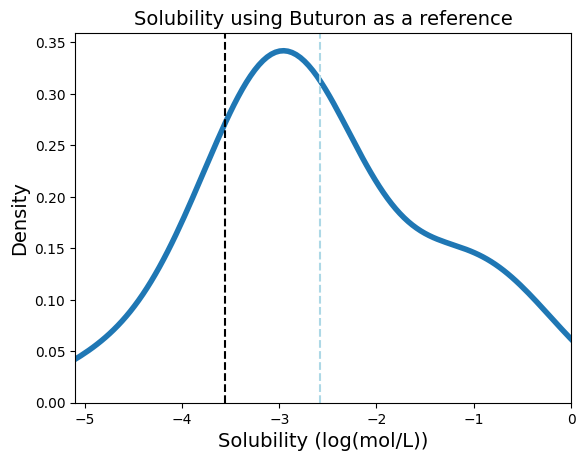

In [7]:
%matplotlib inline
sns.distplot(molecules_df["solubility"], hist=False, kde_kws={"linewidth": 4})
plt.axvline(x=molecules_df["solubility"].mean(), linestyle="--", c="lightblue")
plt.axvline(x=solubility, linestyle="--", c="k")
plt.xlabel("Solubility (log(mol/L))", size=14)
plt.ylabel("Density", size=14)
plt.xlim([min(molecules_df["solubility"].min(), solubility) - .1, 0.0])
plt.title(f"Solubility using {molecule_name} as a reference", size=14)

## Using RXN for Chemistry to find retrosynthetic pathways

At this point, we can explore how we can synthesize the newly generated molecules using [RXN for Chemistry](https://rxn.res.ibm.com)

References:

```txt
Schwaller P., Petraglia R., Zullo V., Nair V. H., Haeuselmann R. A., Pisoni R., Bekas C., Iuliano A., Laino T. (2020). Predicting retrosynthetic pathways using a combined linguistic model and hyper-graph exploration strategy. Chem. Sci., 2020, 11, 3316-3325
```

In [8]:
# some utilities
def collect_reactions_from_retrosynthesis(tree: Dict) -> List[str]:
    reactions = []
    if "children" in tree and len(tree["children"]):
        reactions.append(
            AllChem.ReactionFromSmarts(f"{'.'.join([node['smiles'] for node in tree['children']])}>>{tree['smiles']}", useSmiles=True))
    for node in tree["children"]:
        reactions.extend(collect_reactions_from_retrosynthesis(node))
    return reactions

In [9]:
# setup wrapper and project, get the RXN for Chemistry API key from here: https://rxn.res.ibm.com/rxn/user/profile
api_key = "API_KEY"
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
# NOTE: you can create a project or set an esiting one using:
# rxn4chemistry_wrapper.set_project("PROJECT_ID")
_ = rxn4chemistry_wrapper.create_project("gt4sd_and_rxn_demo")

In [10]:
# run the prediction
response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(product=molecules_df["smiles"][0])

In [11]:
# get the results via polling
results = polling2.poll(
   lambda: rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(response["prediction_id"]),
   step=30,
   check_success=lambda response: len(response.get("retrosynthetic_paths", [])) > 0,
   timeout=1200
)

Showing path 0 with confidence 1.0


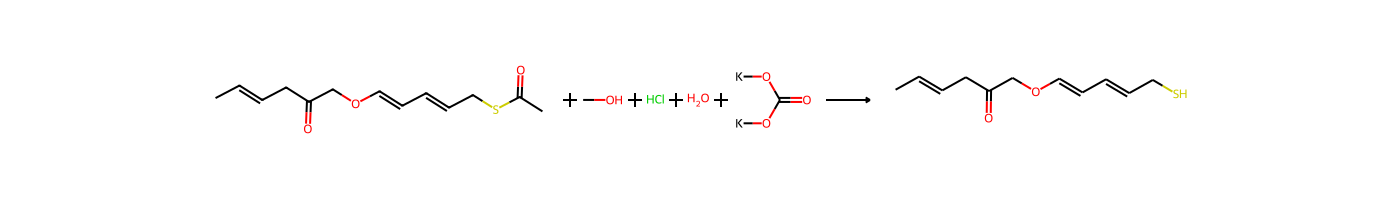

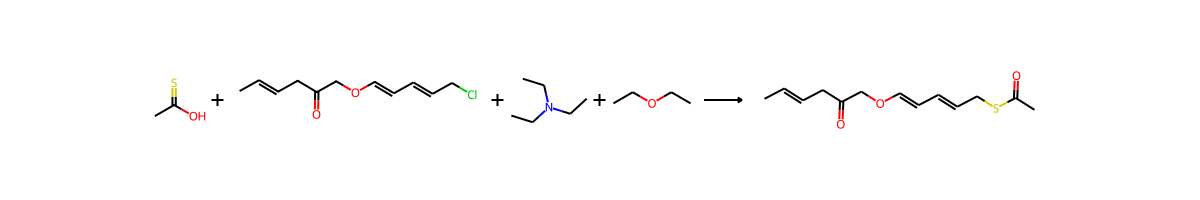

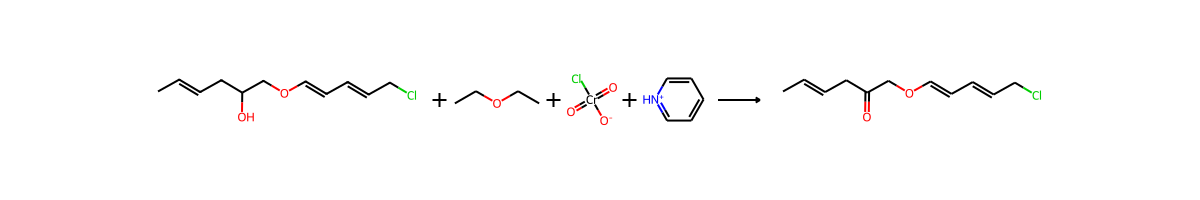

Showing path 1 with confidence 0.999


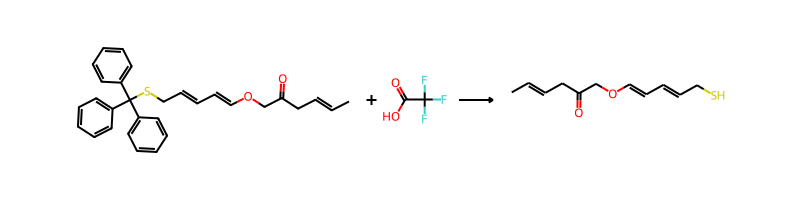

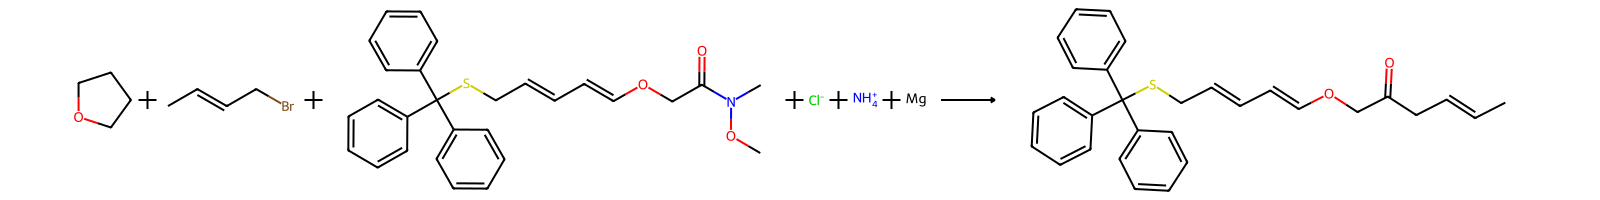

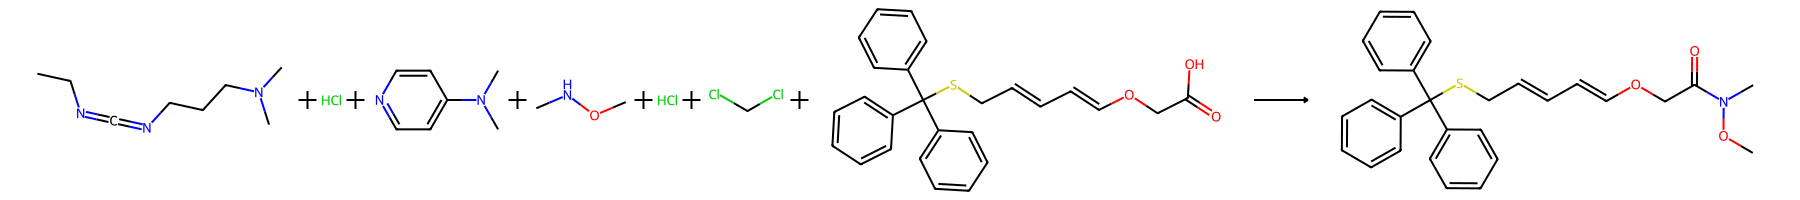

Showing path 2 with confidence 0.999


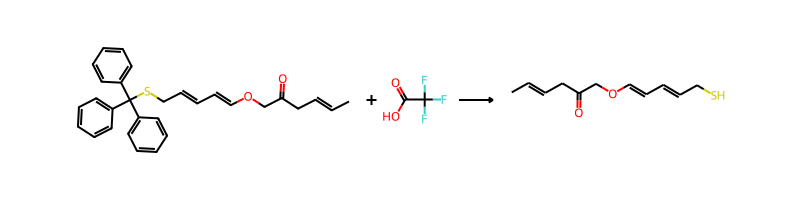

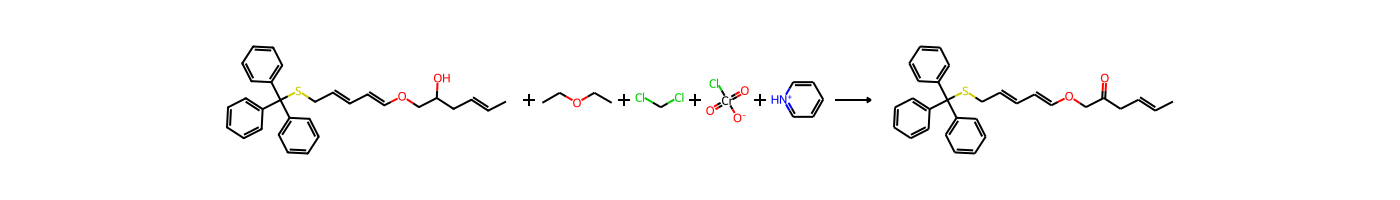

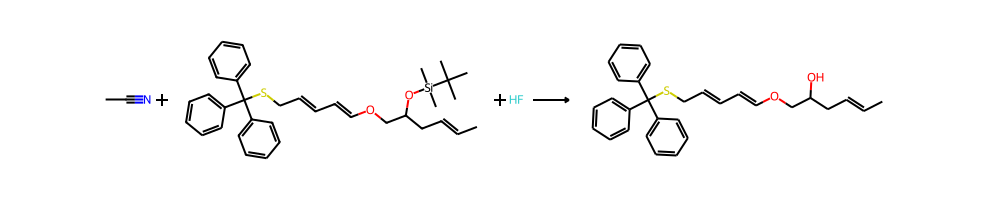

Showing path 3 with confidence 1.0


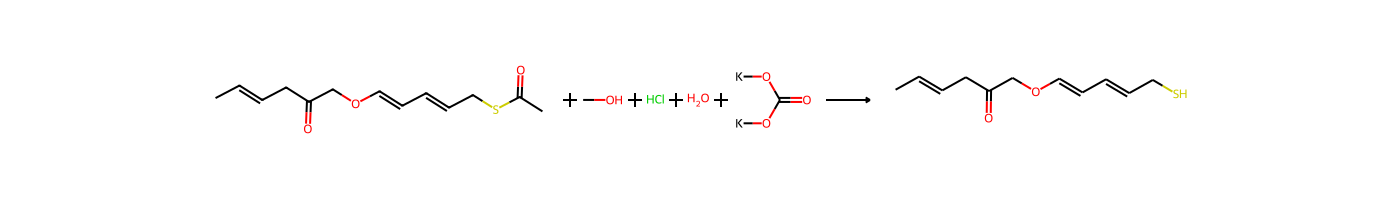

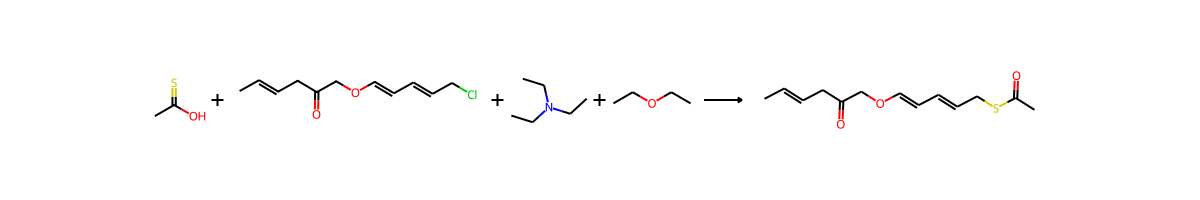

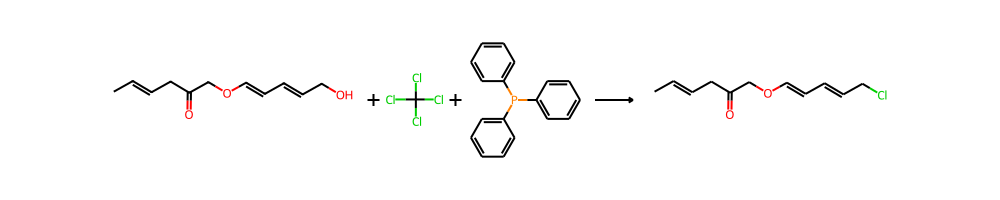

Showing path 4 with confidence 0.999


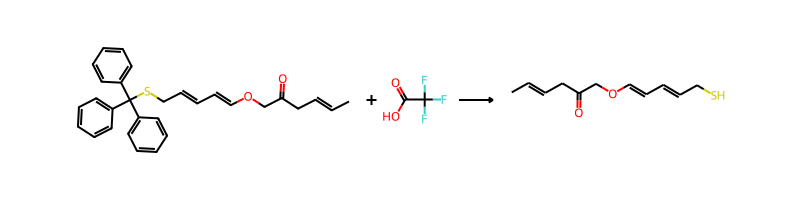

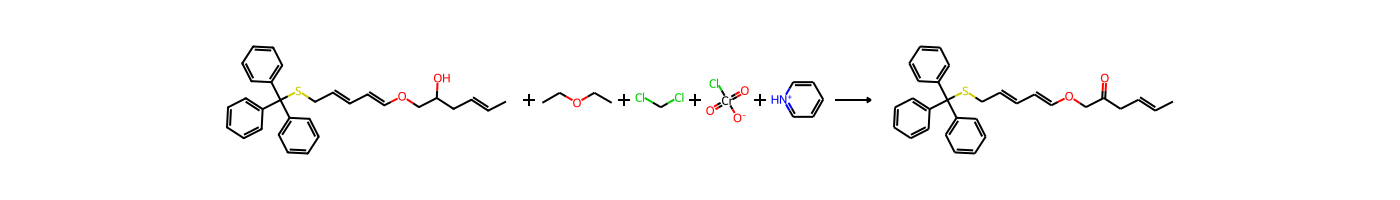

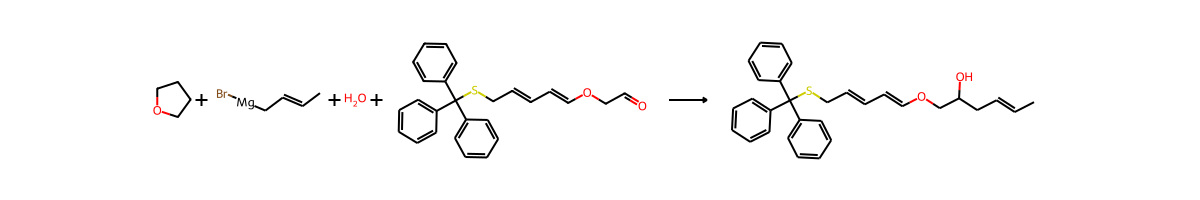

Showing path 5 with confidence 1.0


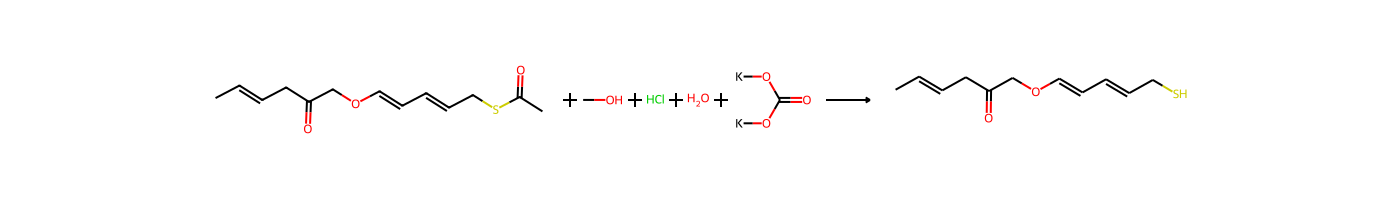

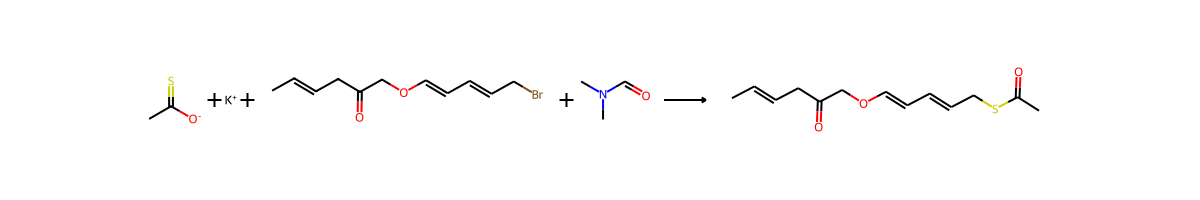

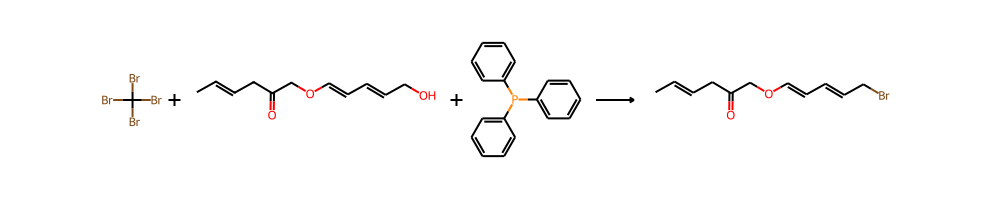

Showing path 6 with confidence 1.0


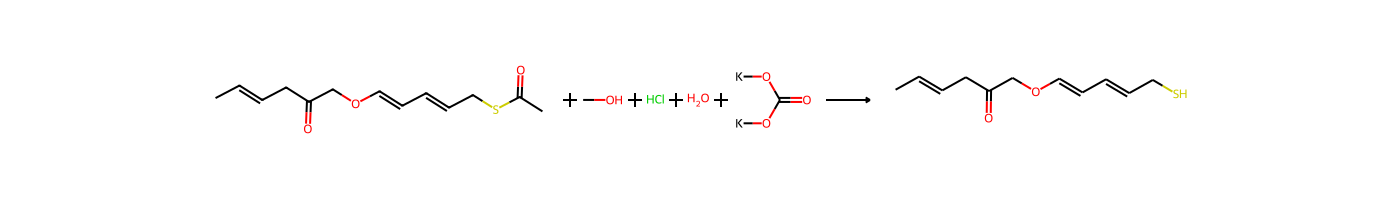

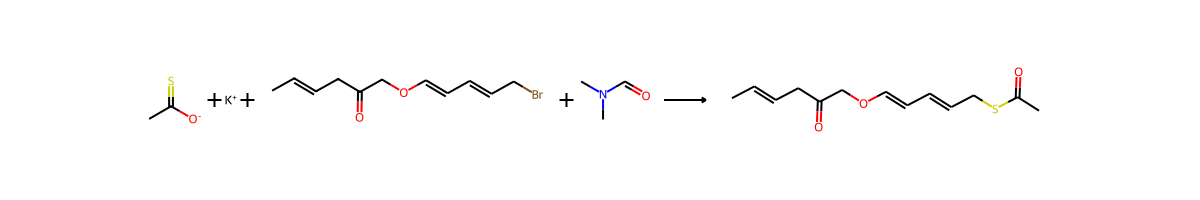

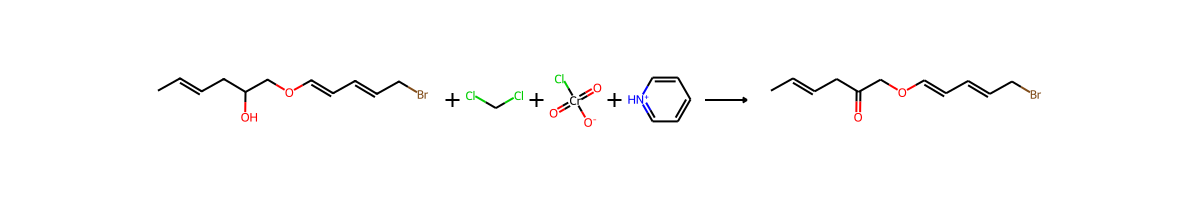

Showing path 7 with confidence 1.0


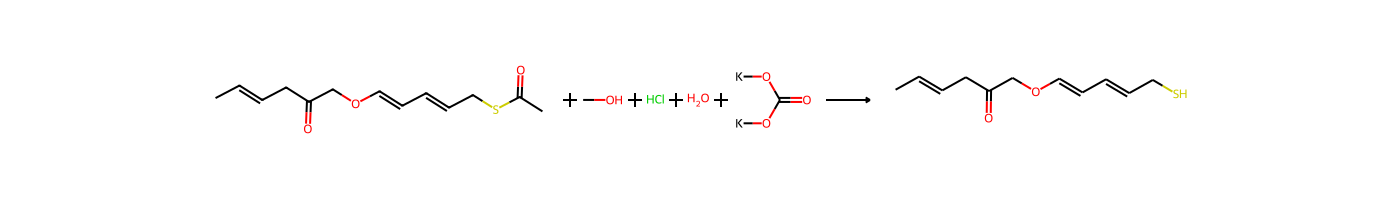

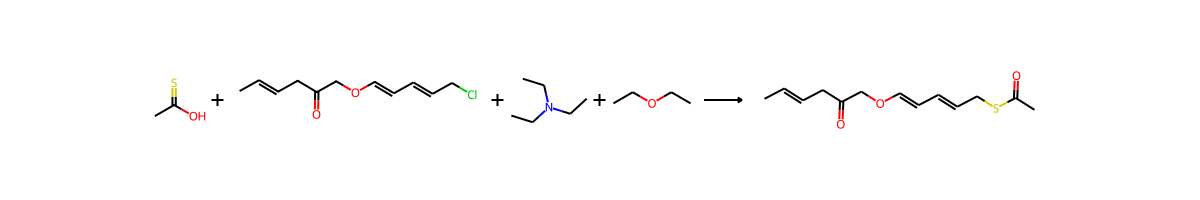

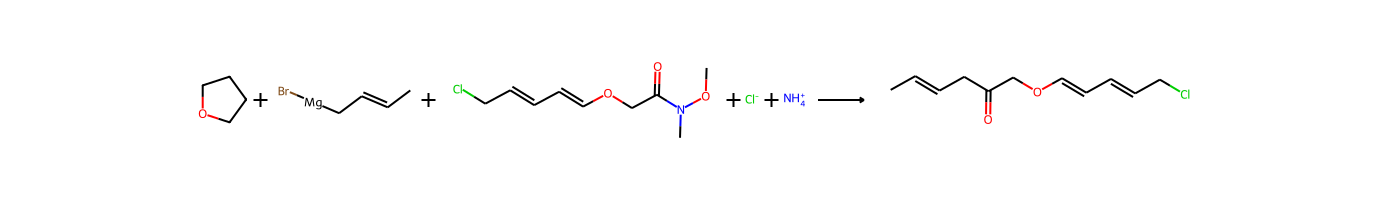

Showing path 8 with confidence 1.0


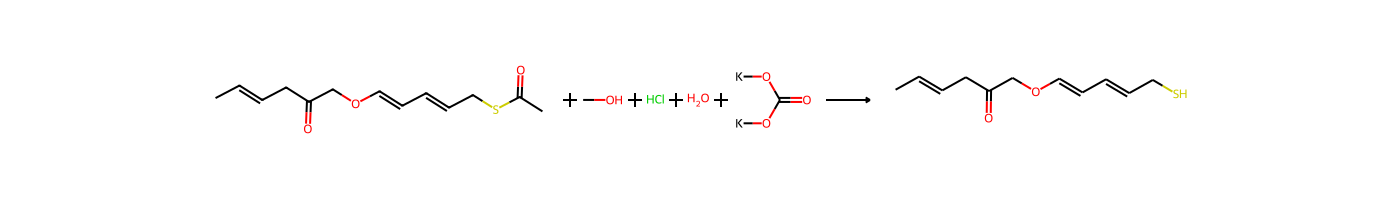

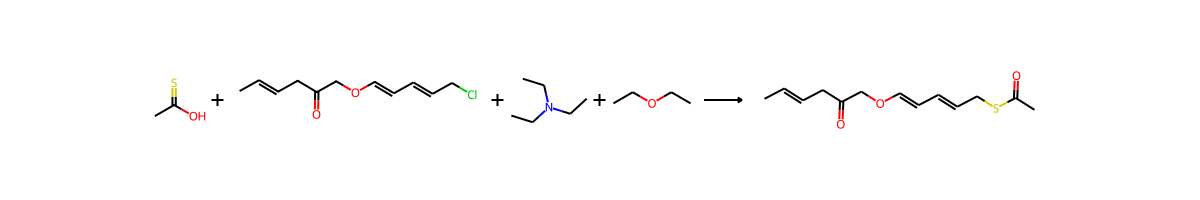

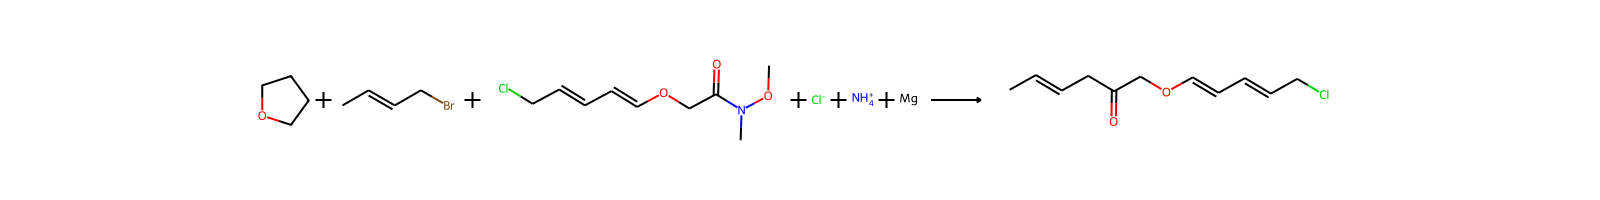

Showing path 9 with confidence 1.0


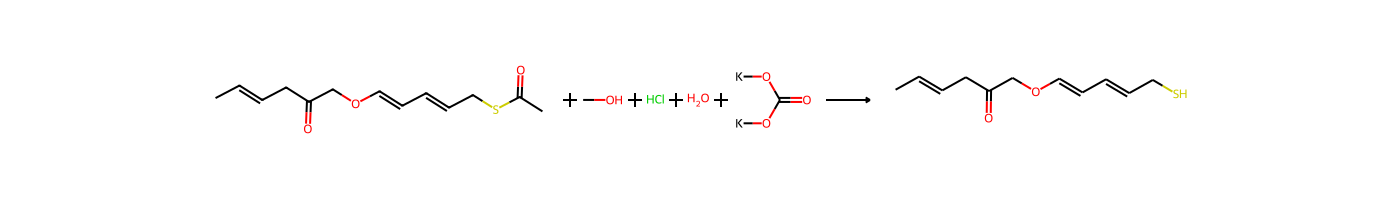

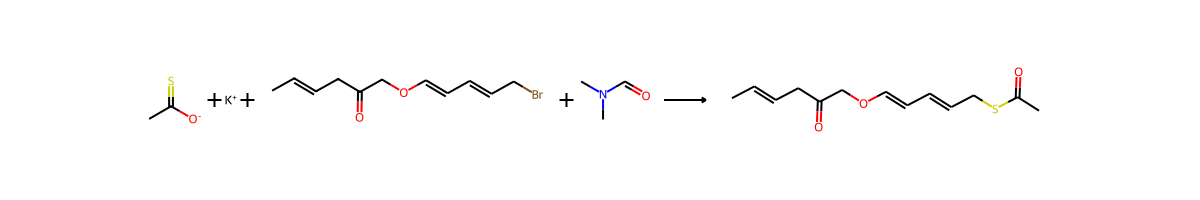

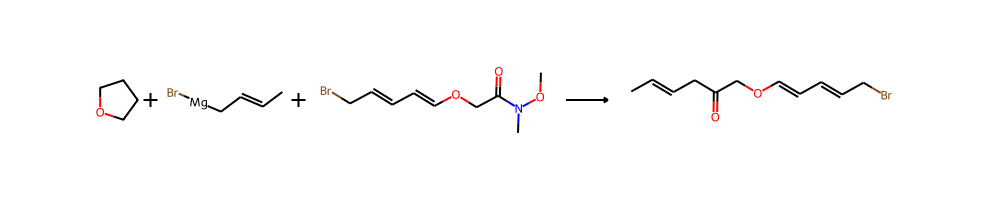

Showing path 10 with confidence 0.999


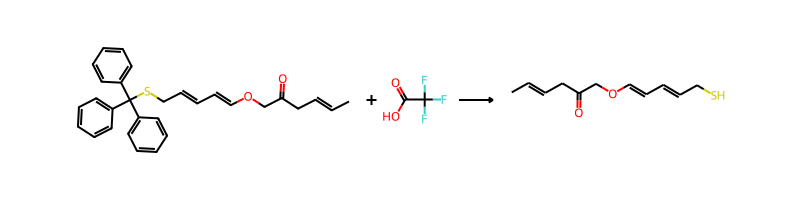

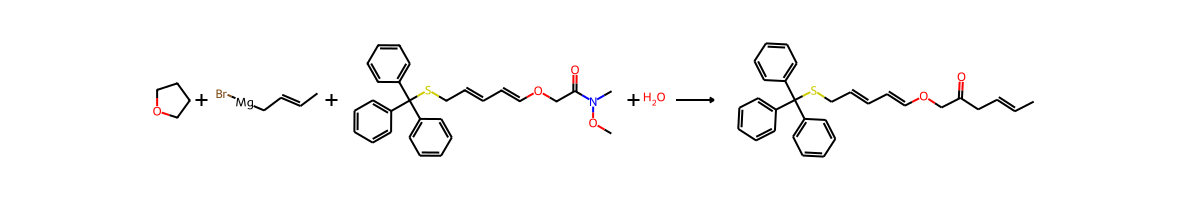

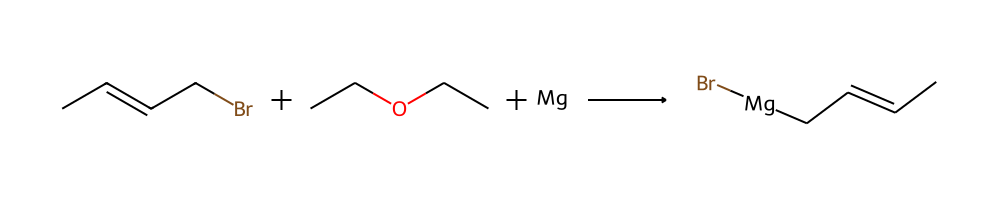

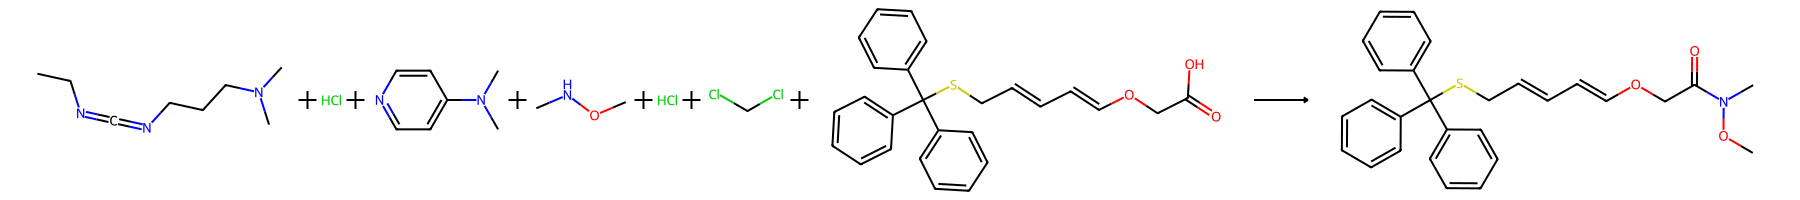

Showing path 11 with confidence 0.999


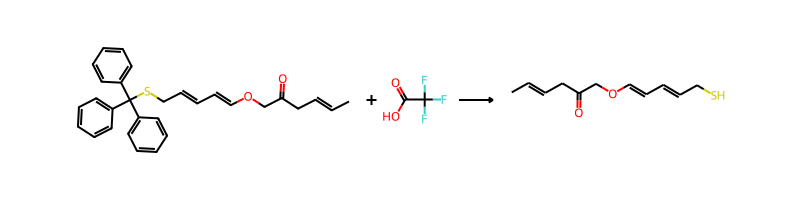

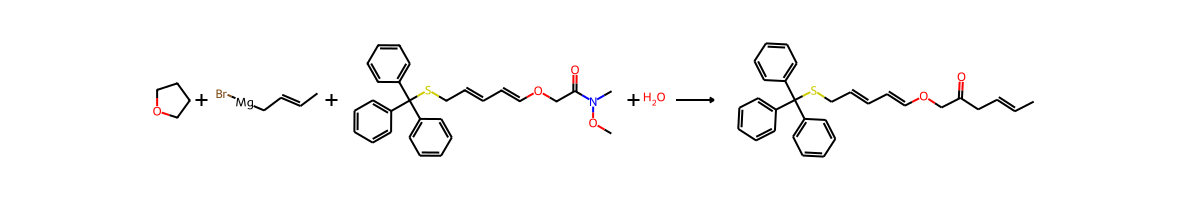

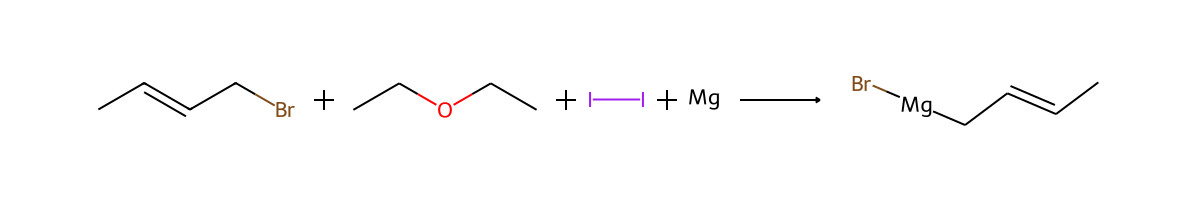

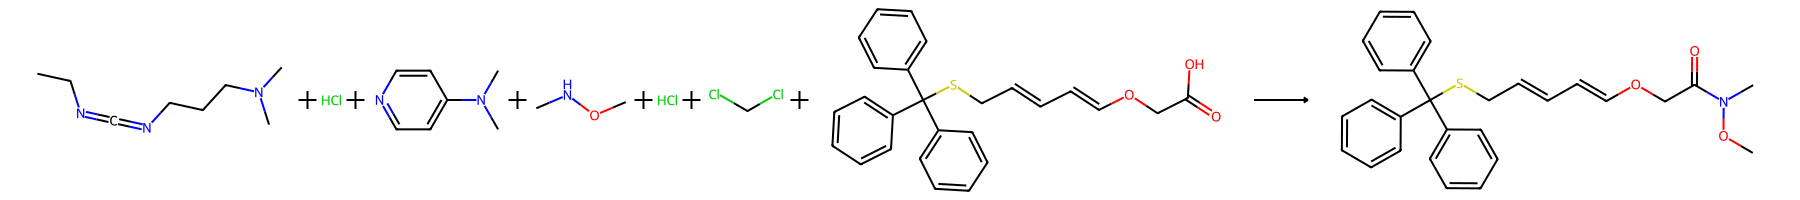

Showing path 12 with confidence 0.999


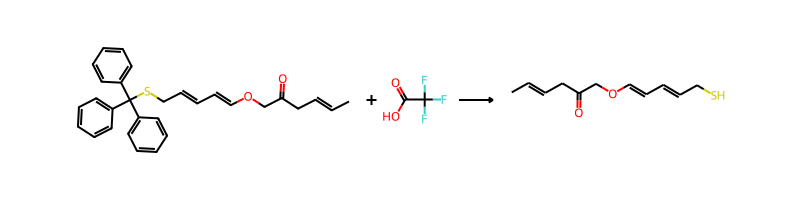

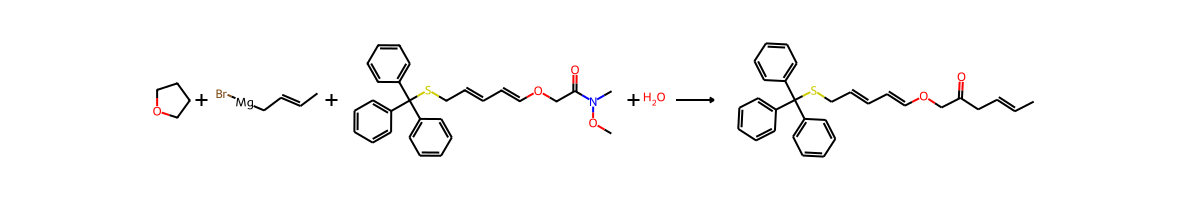

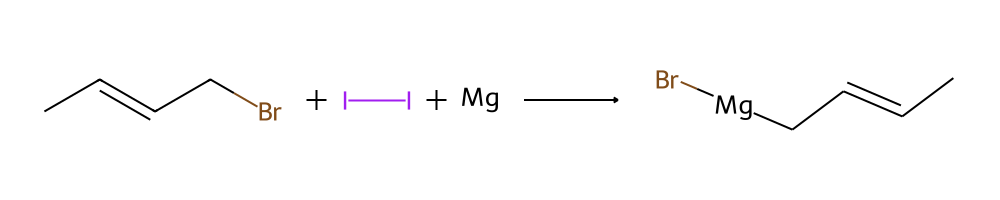

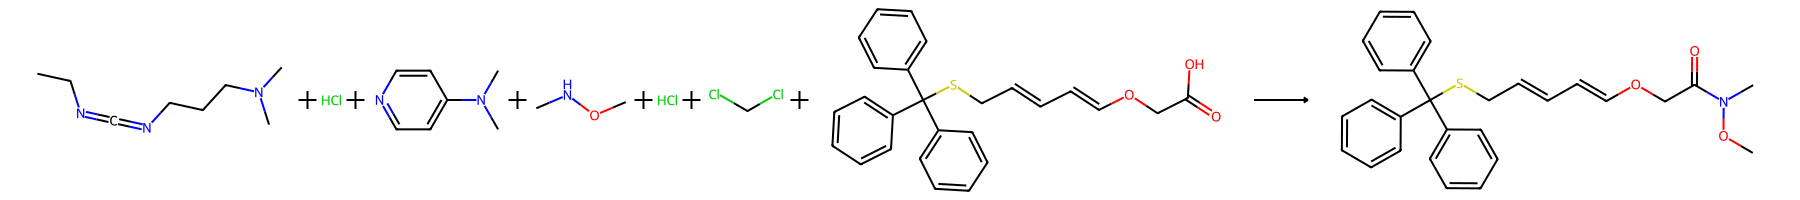

Showing path 13 with confidence 1.0


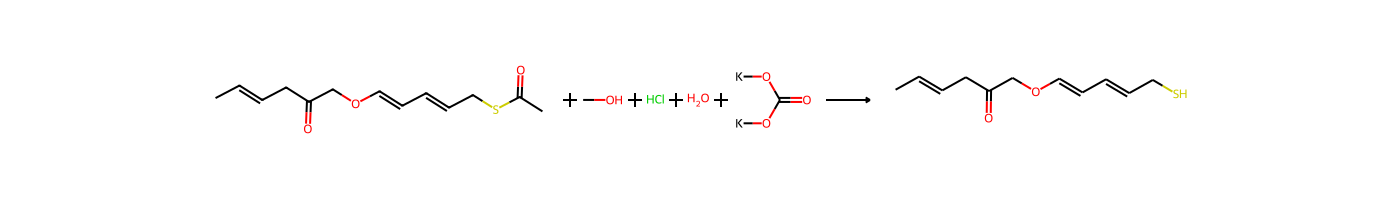

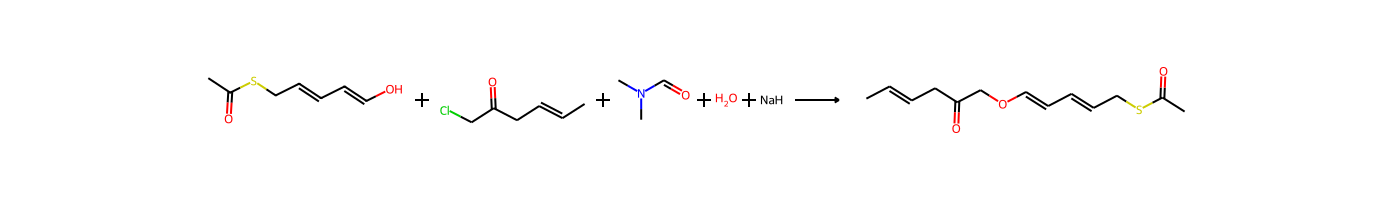

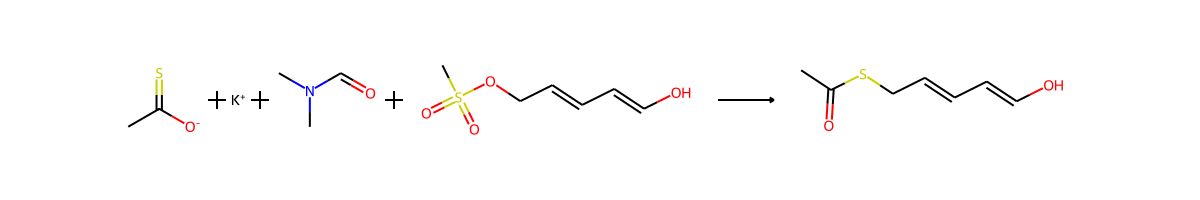

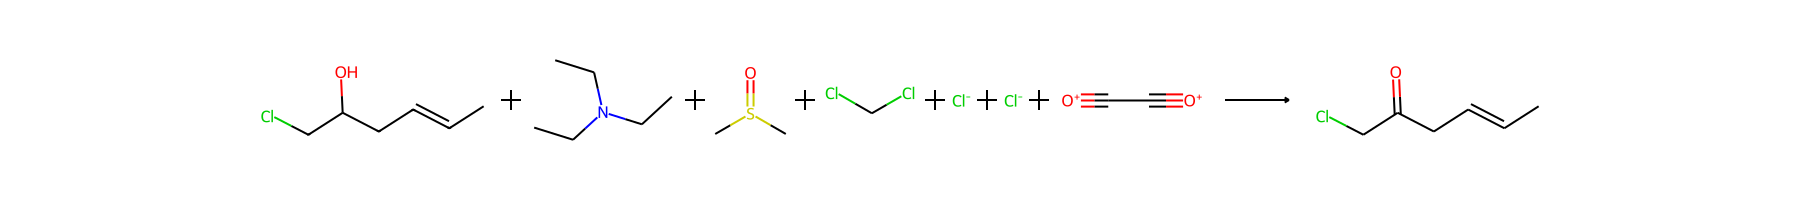

Showing path 14 with confidence 1.0


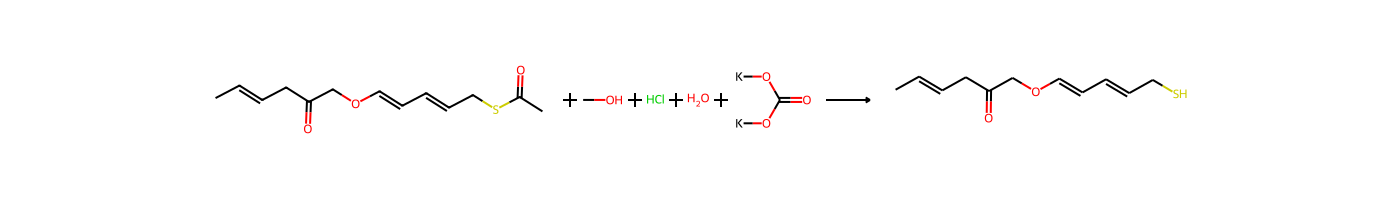

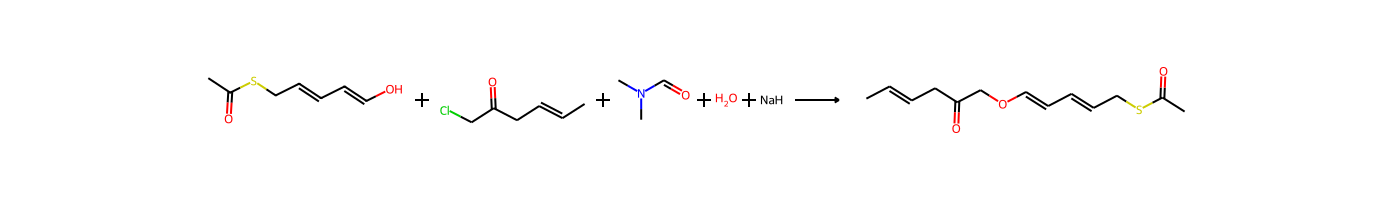

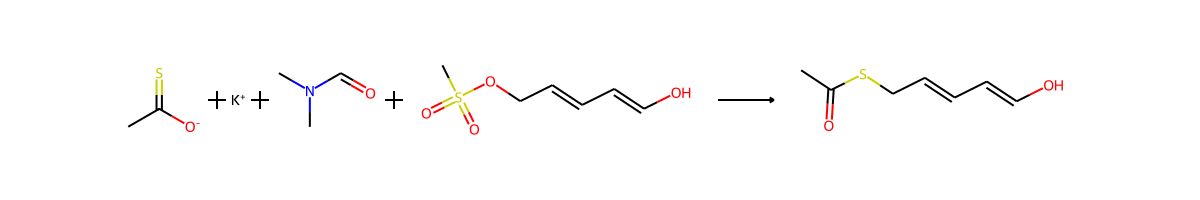

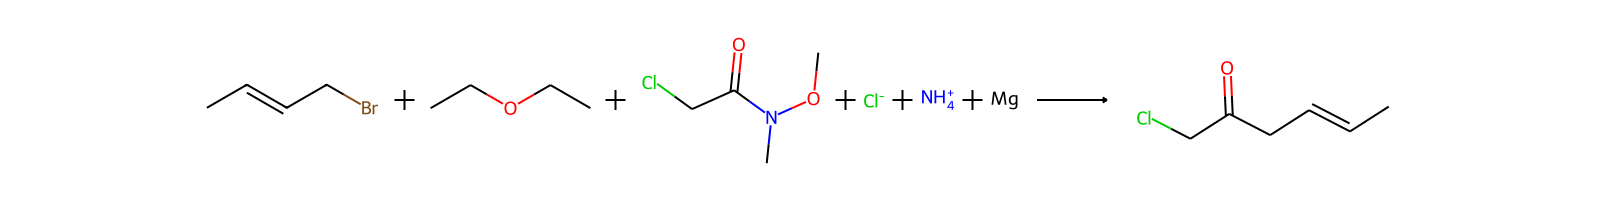

Showing path 15 with confidence 1.0


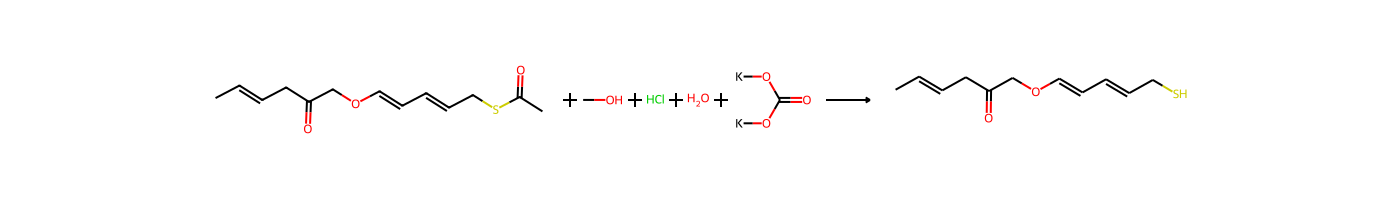

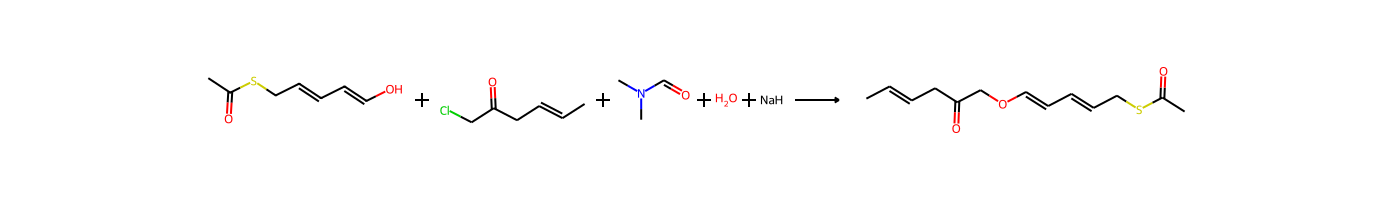

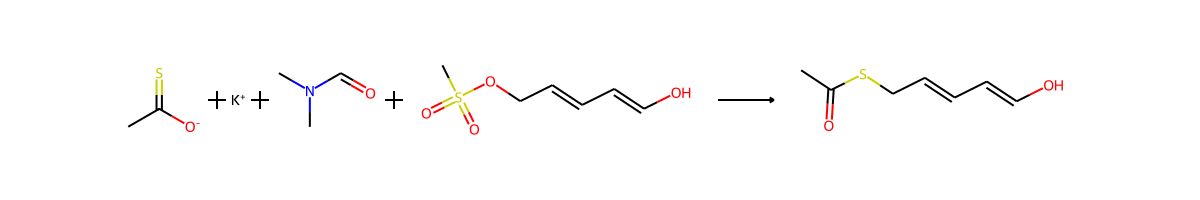

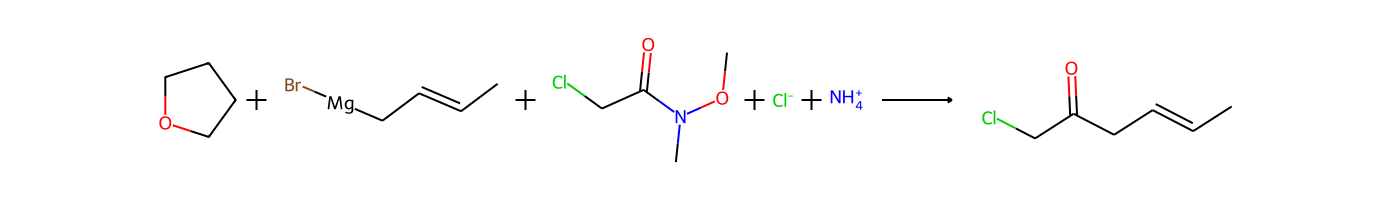

Showing path 16 with confidence 1.0


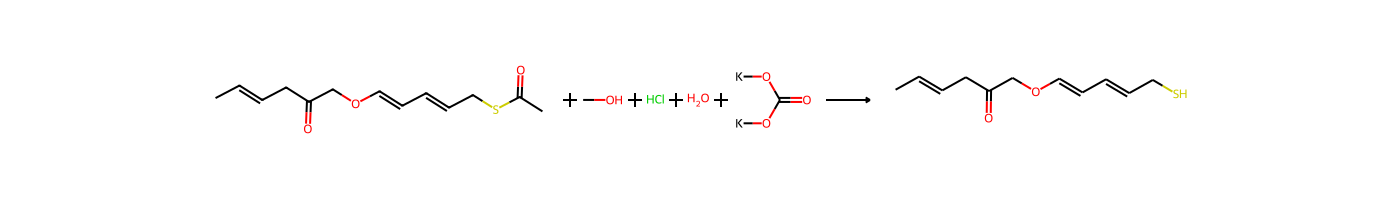

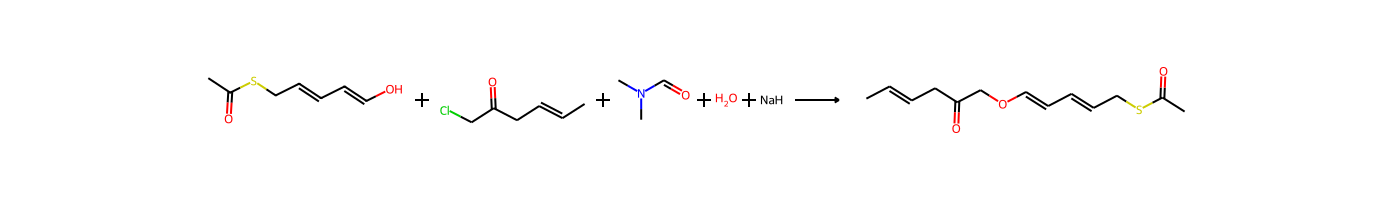

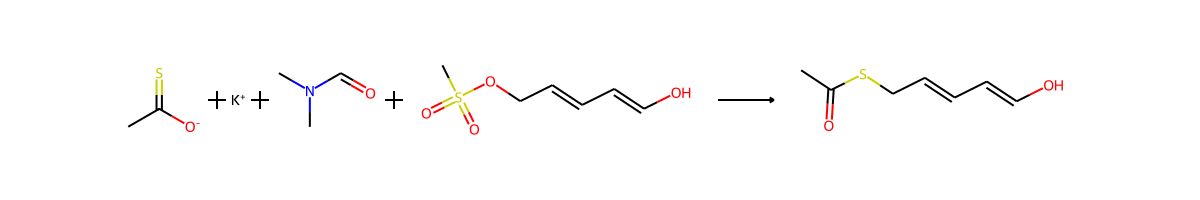

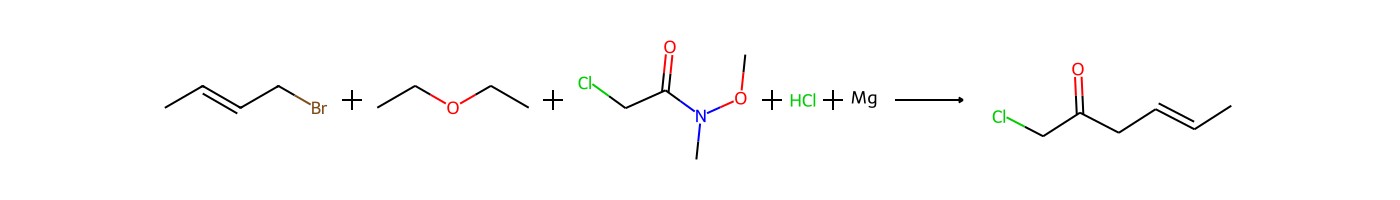

Showing path 17 with confidence 1.0


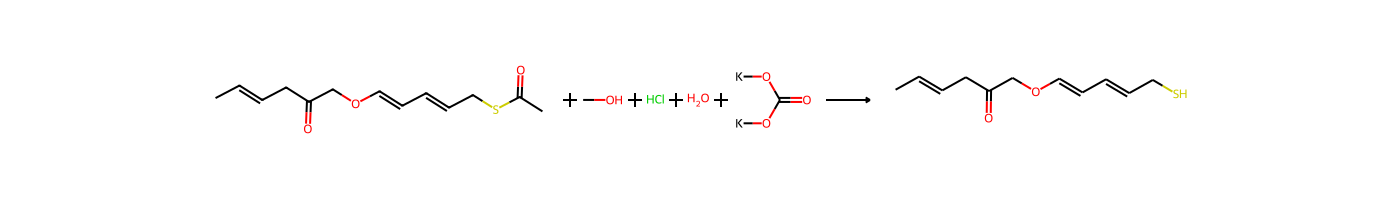

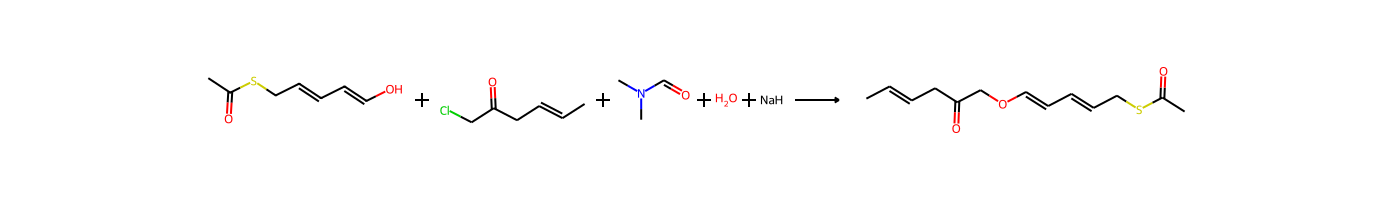

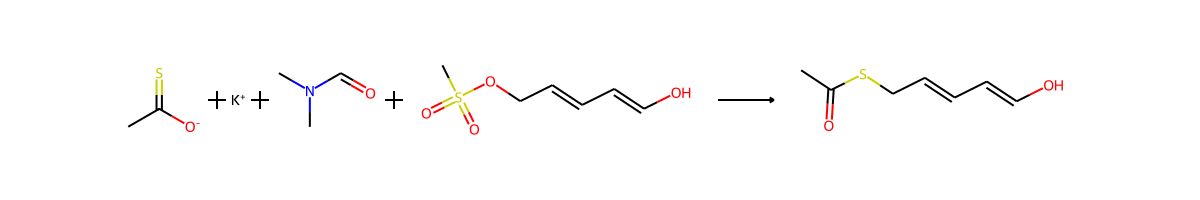

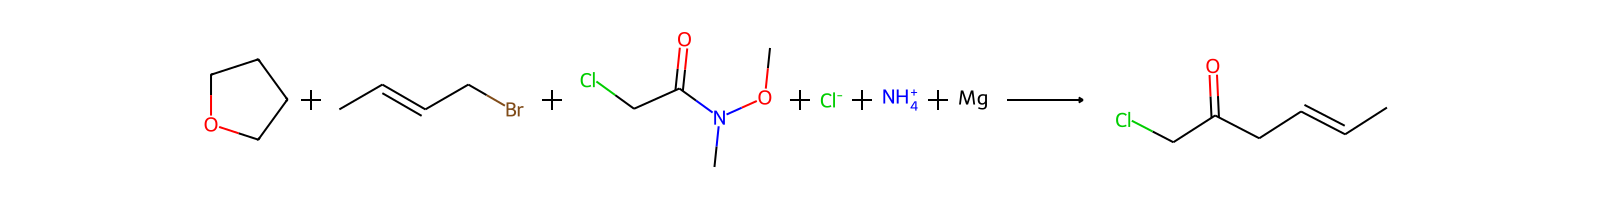

Showing path 18 with confidence 1.0


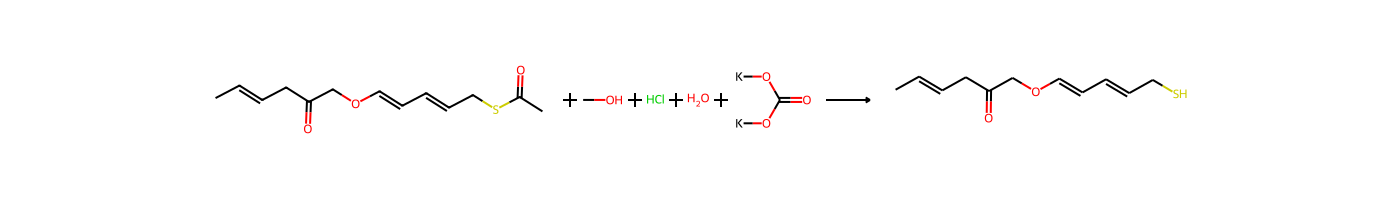

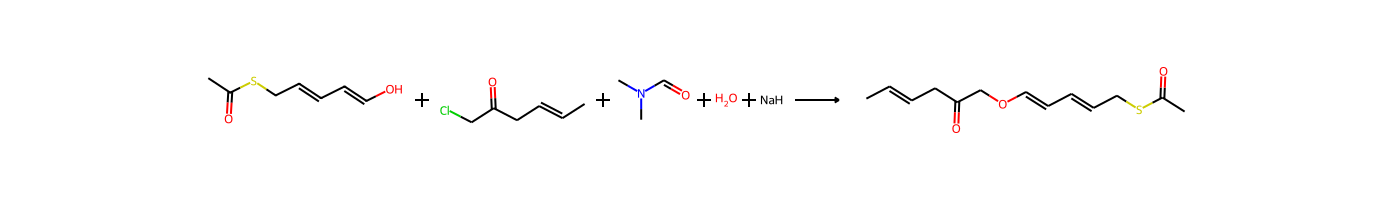

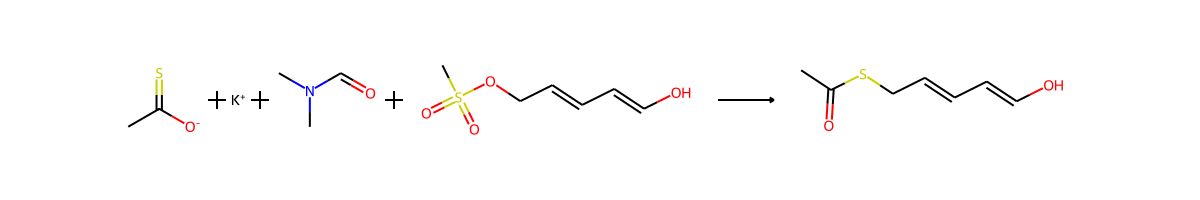

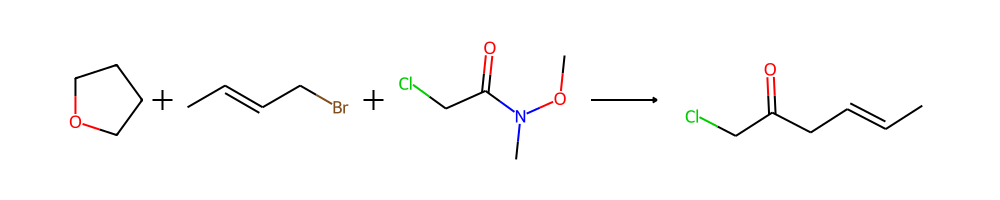

Showing path 19 with confidence 1.0


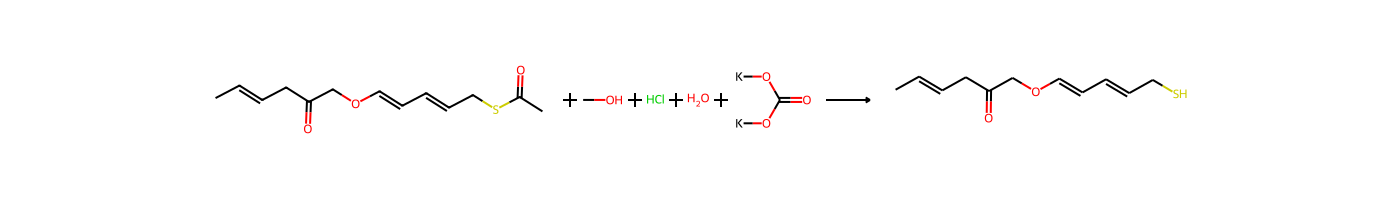

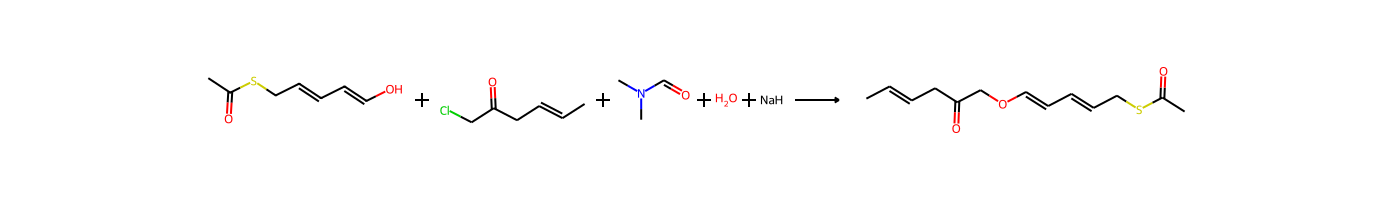

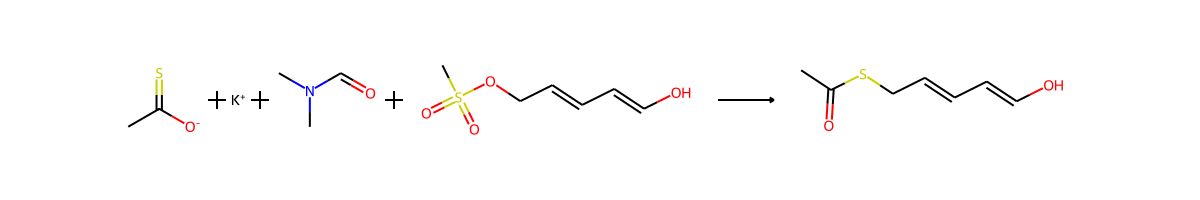

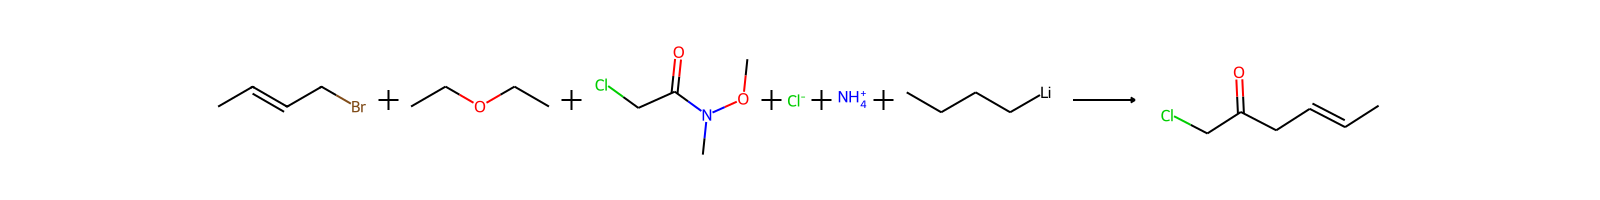

Showing path 20 with confidence 1.0


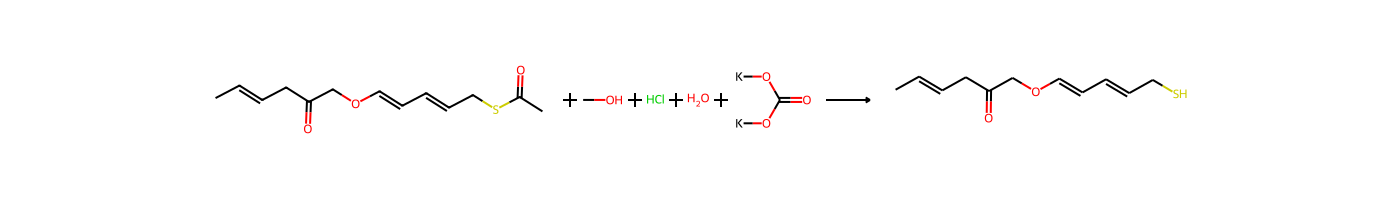

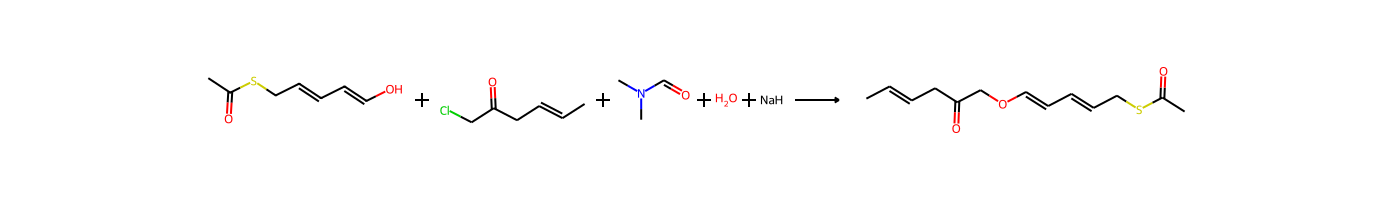

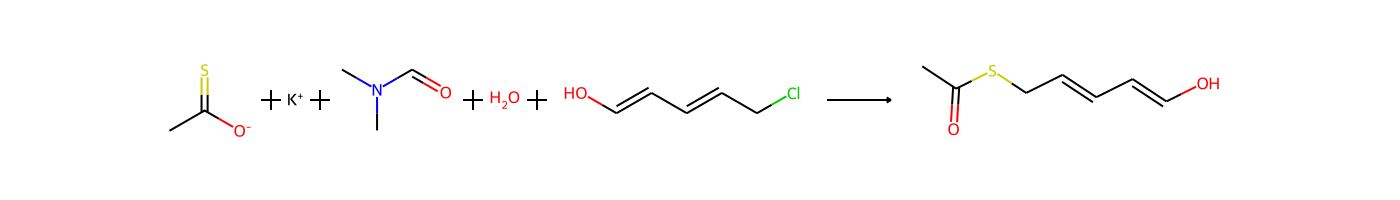

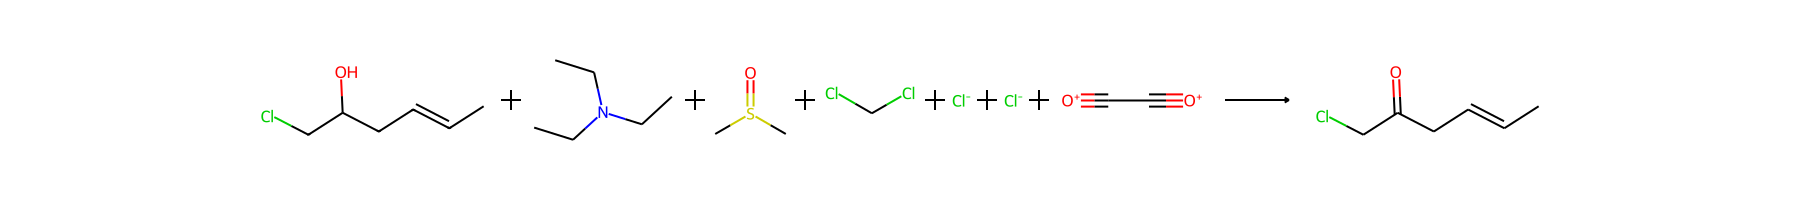

Showing path 21 with confidence 1.0


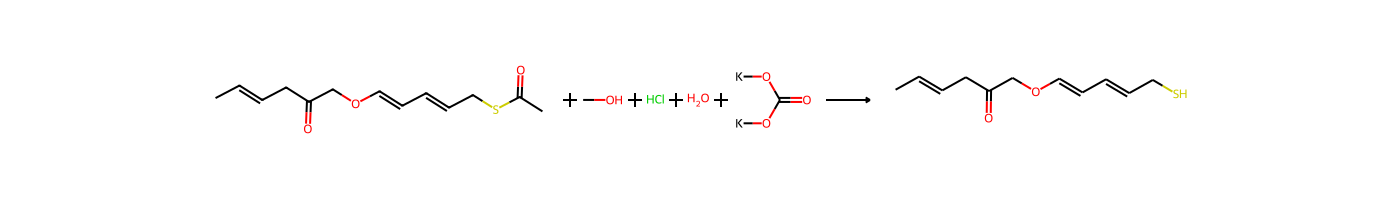

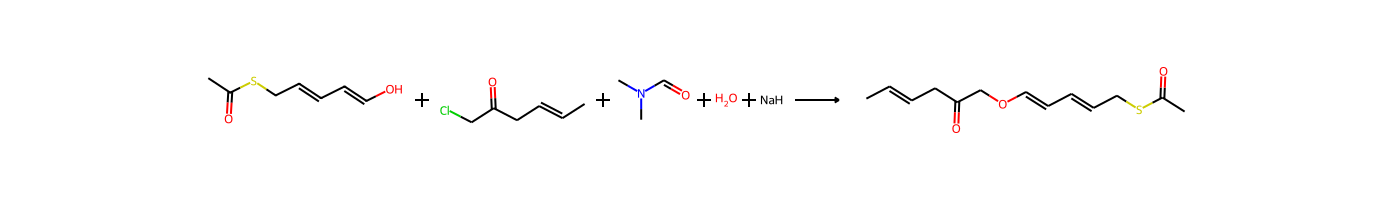

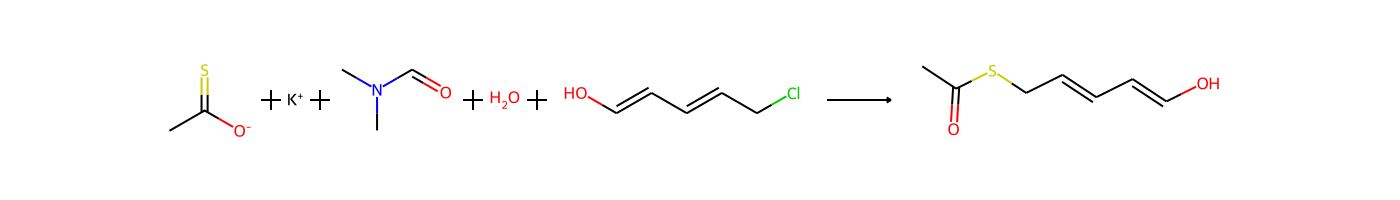

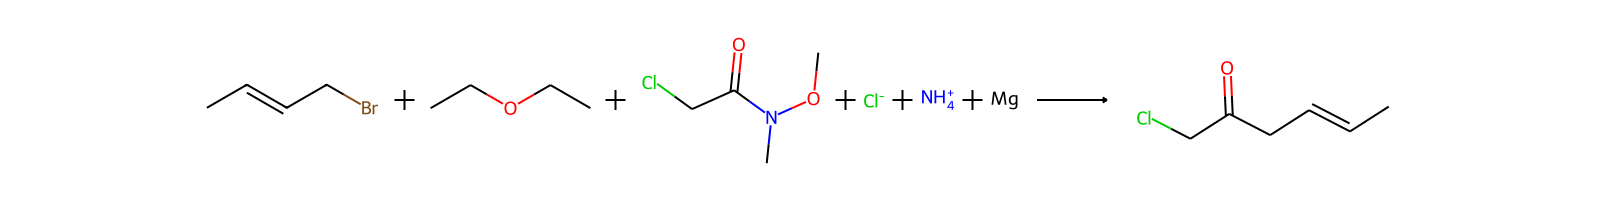

Showing path 22 with confidence 1.0


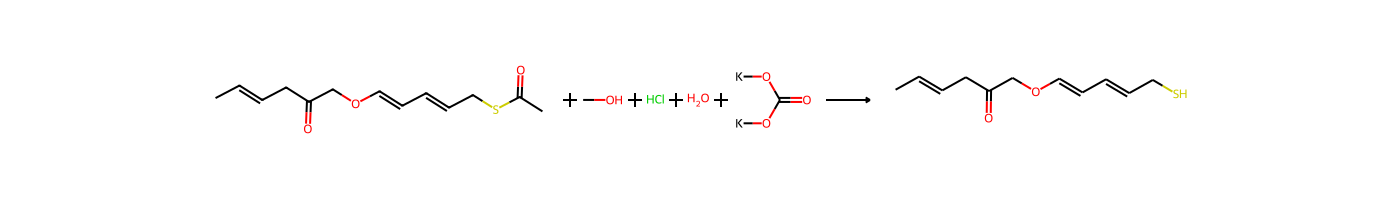

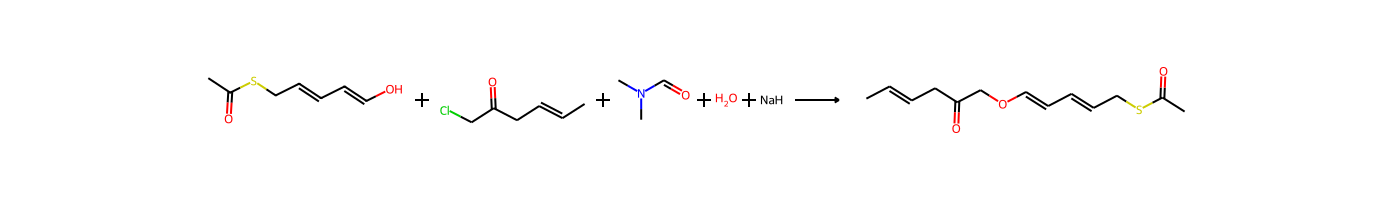

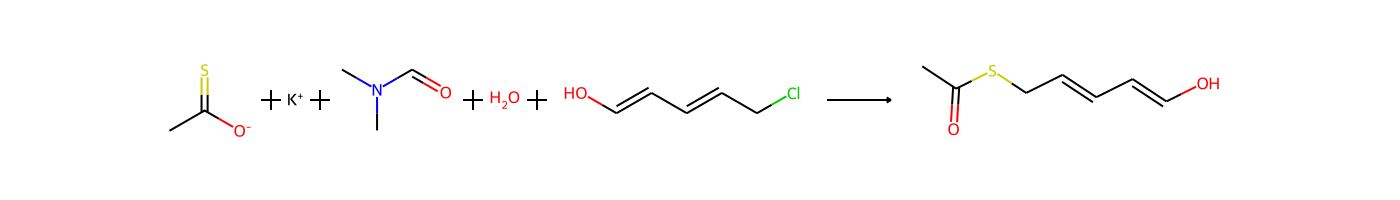

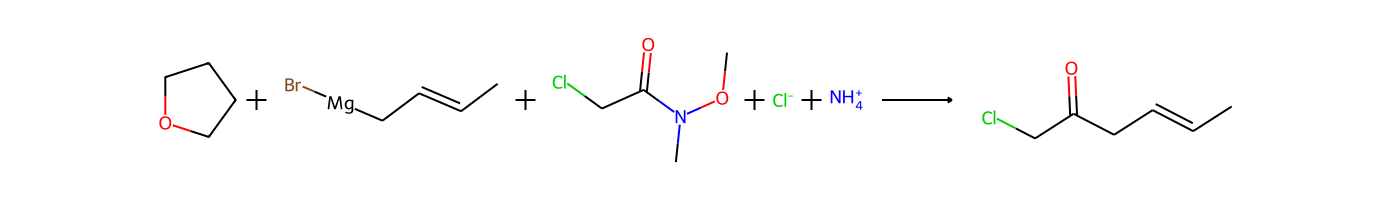

Showing path 23 with confidence 1.0


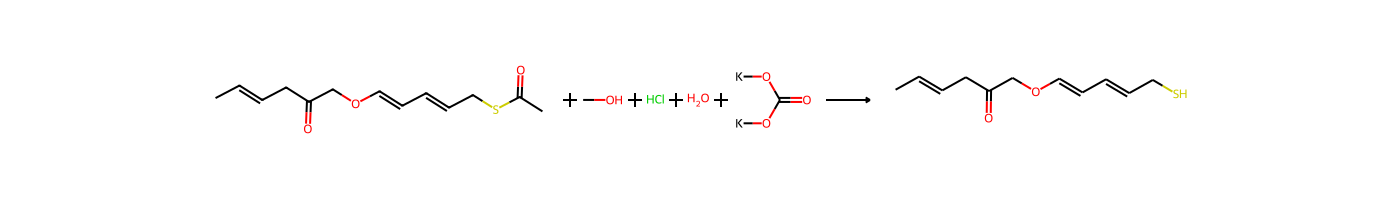

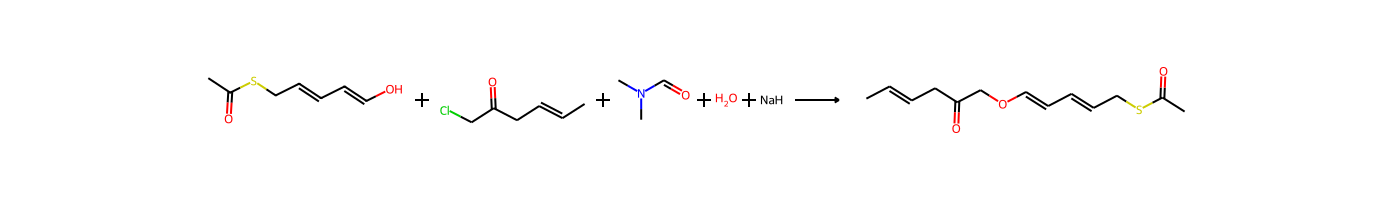

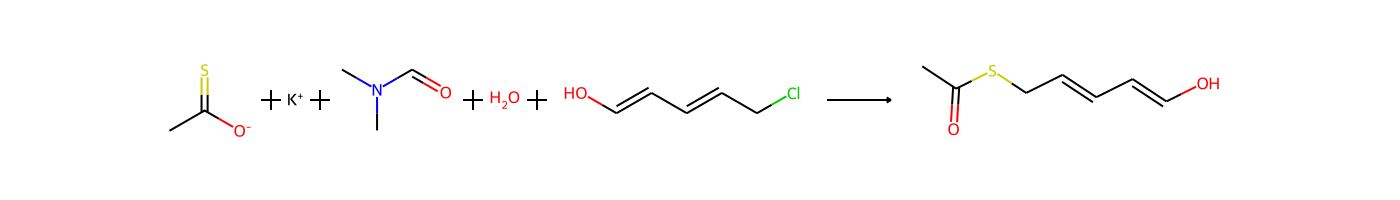

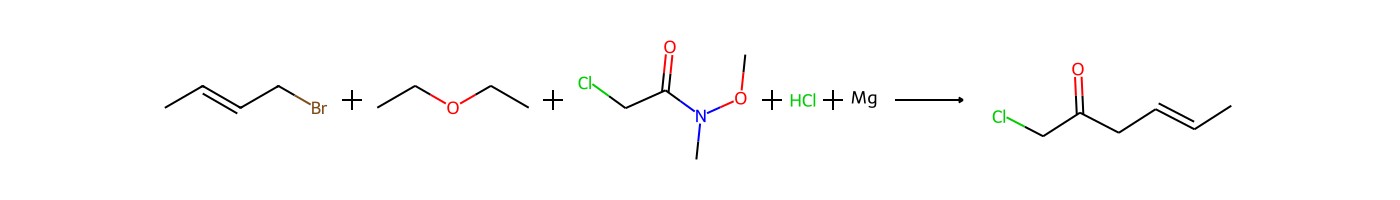

Showing path 24 with confidence 1.0


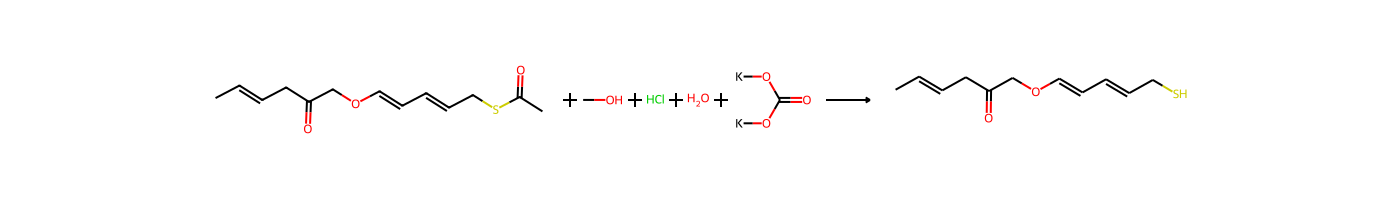

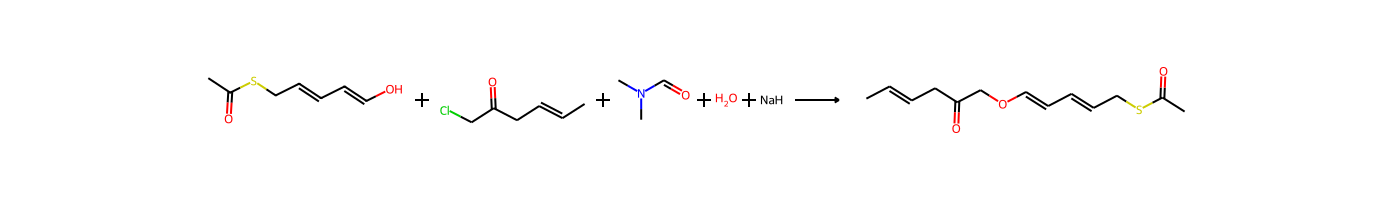

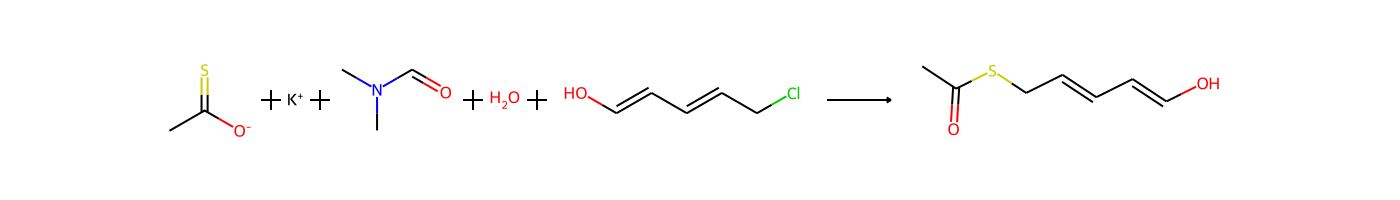

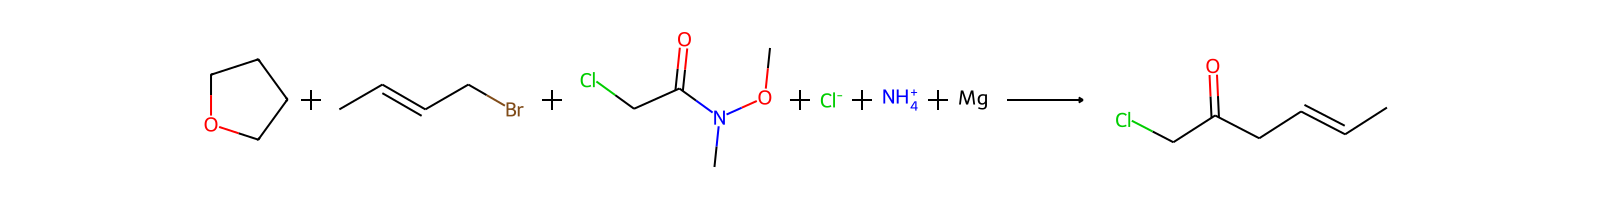

Showing path 25 with confidence 0.999


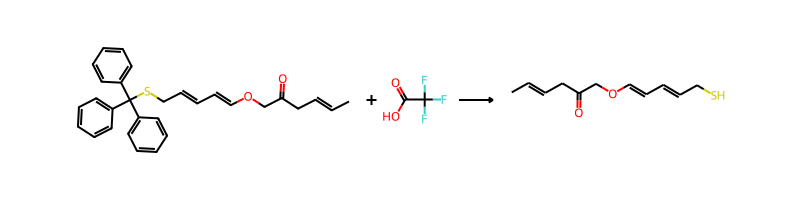

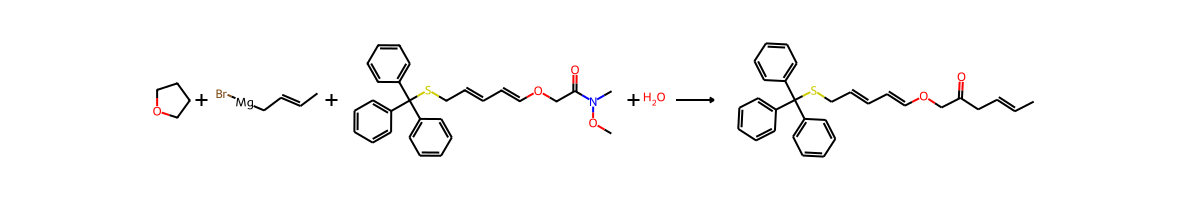

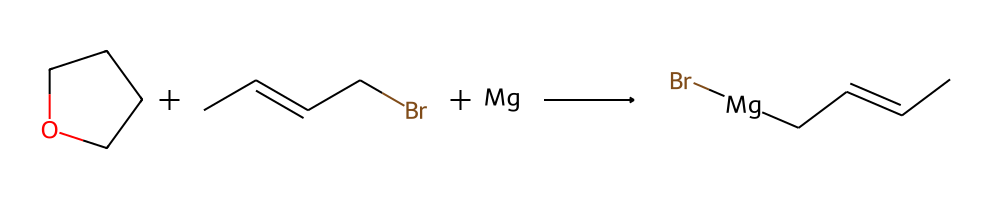

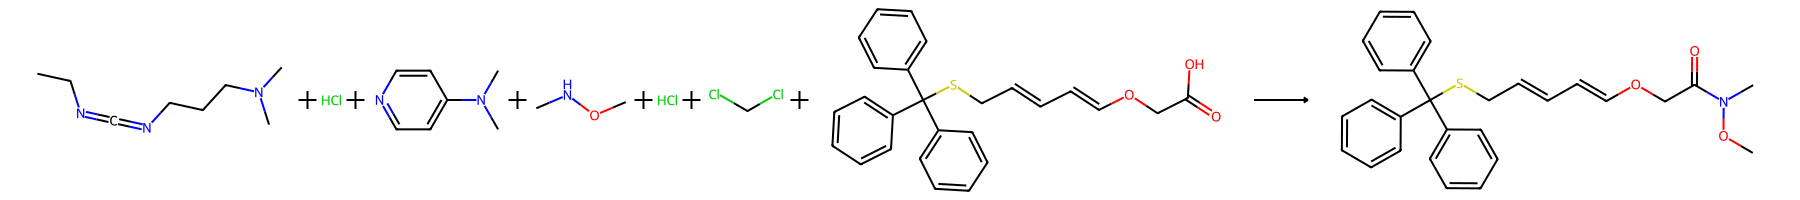

Showing path 26 with confidence 1.0


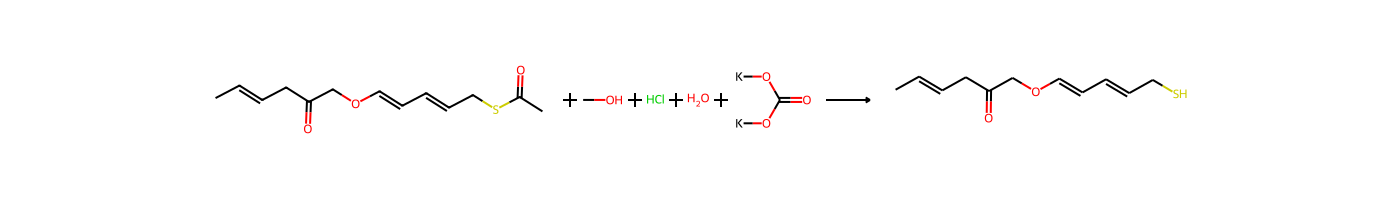

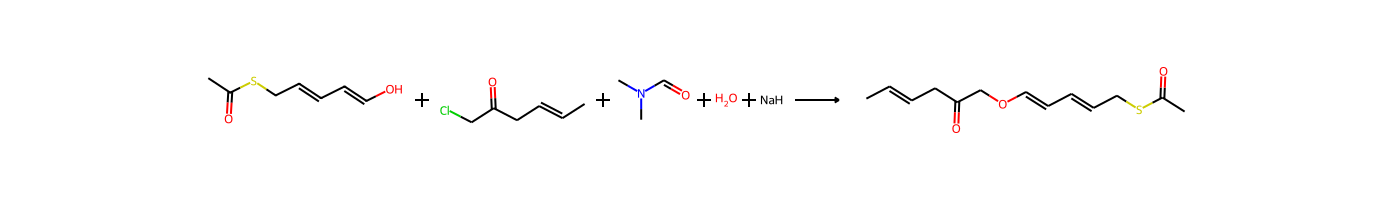

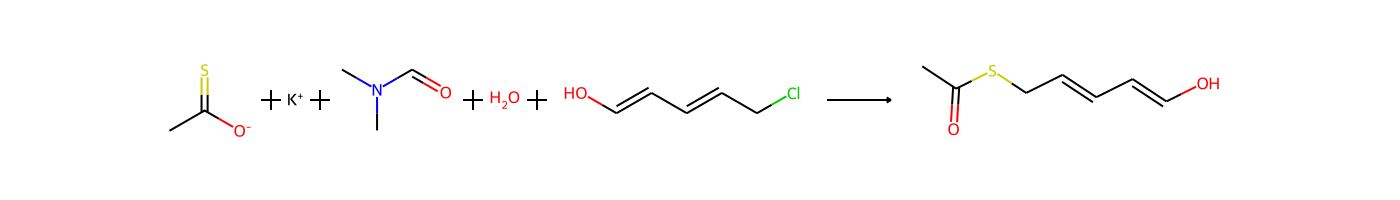

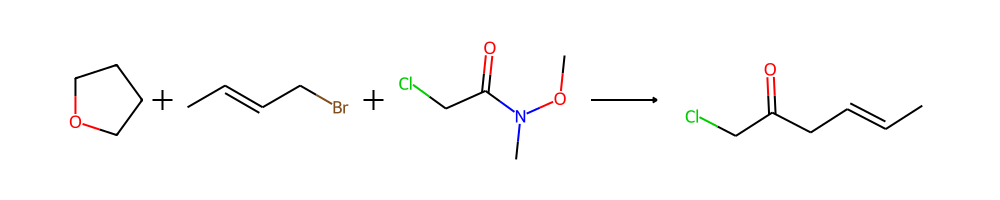

Showing path 27 with confidence 1.0


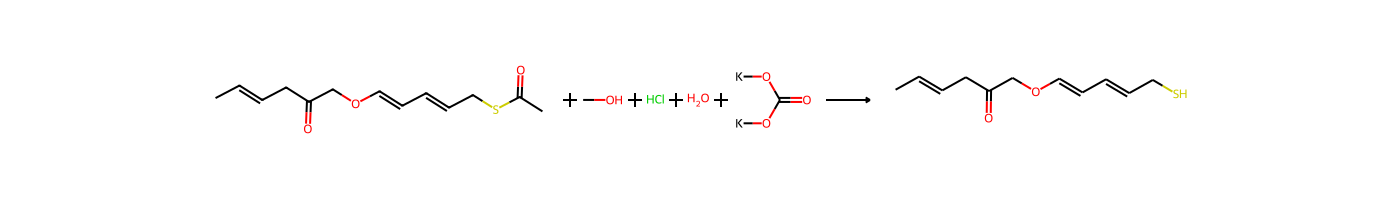

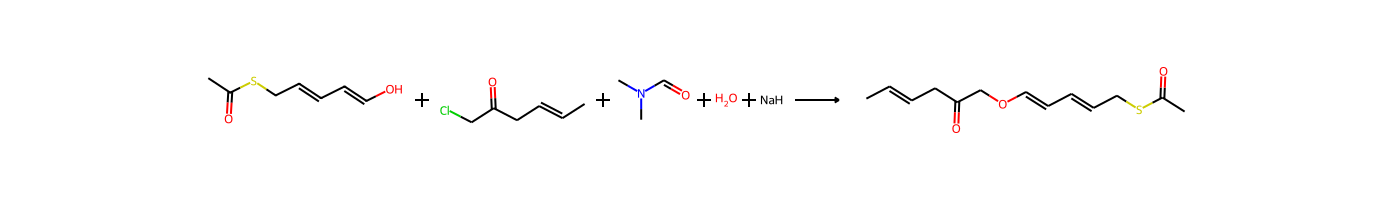

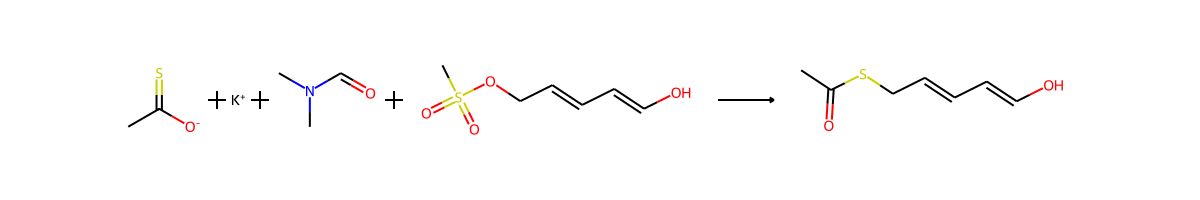

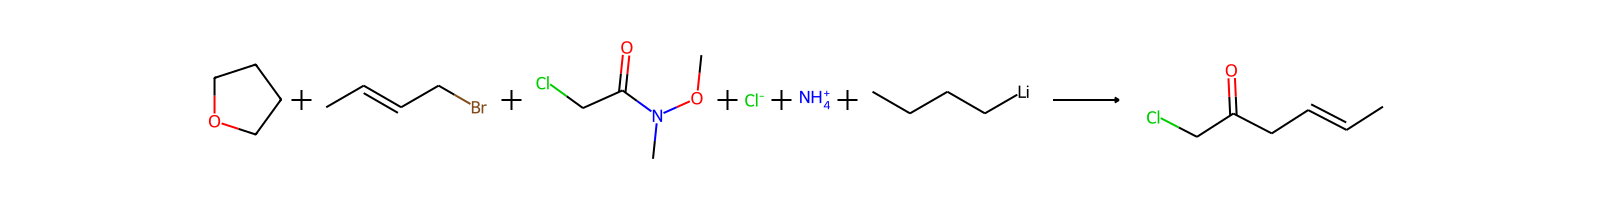

Showing path 28 with confidence 1.0


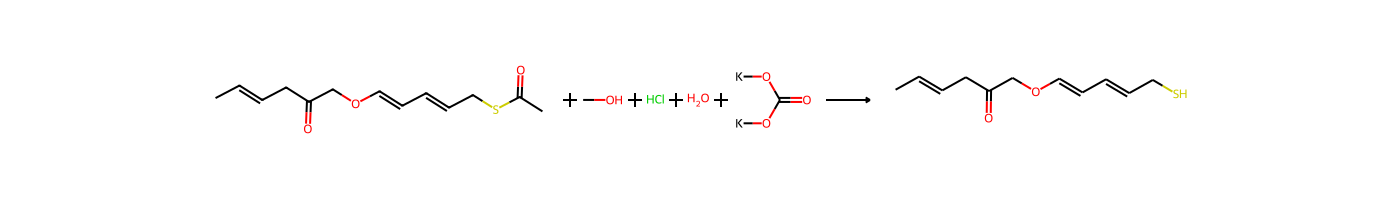

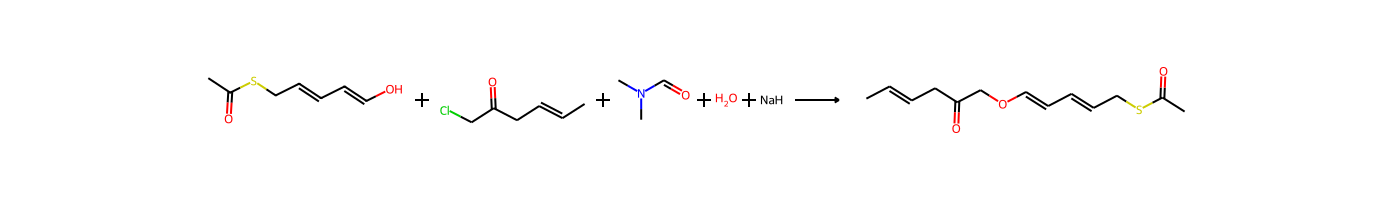

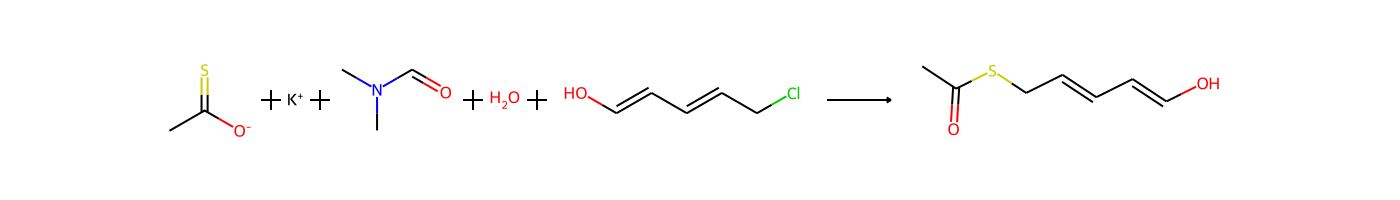

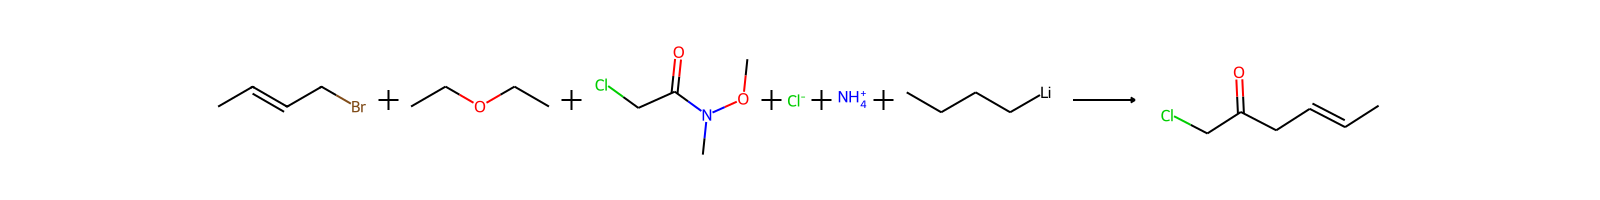

Showing path 29 with confidence 0.999


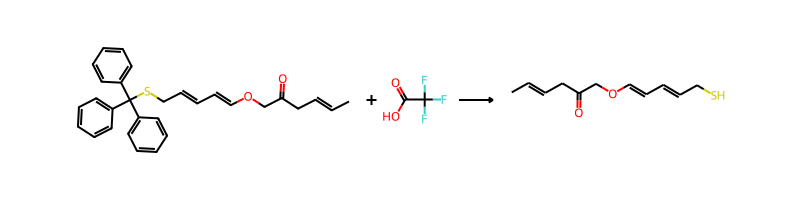

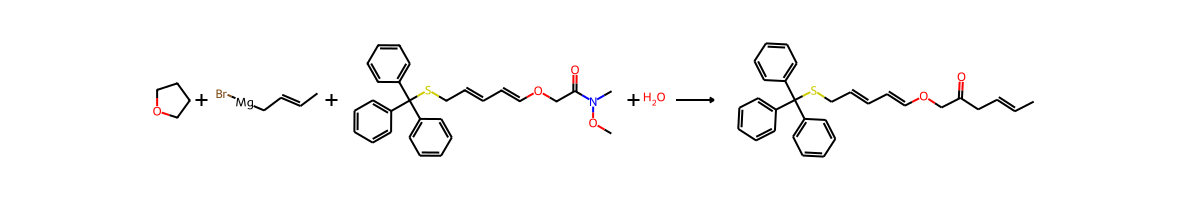

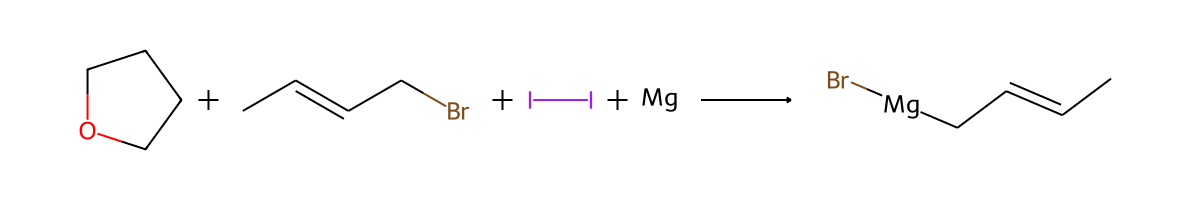

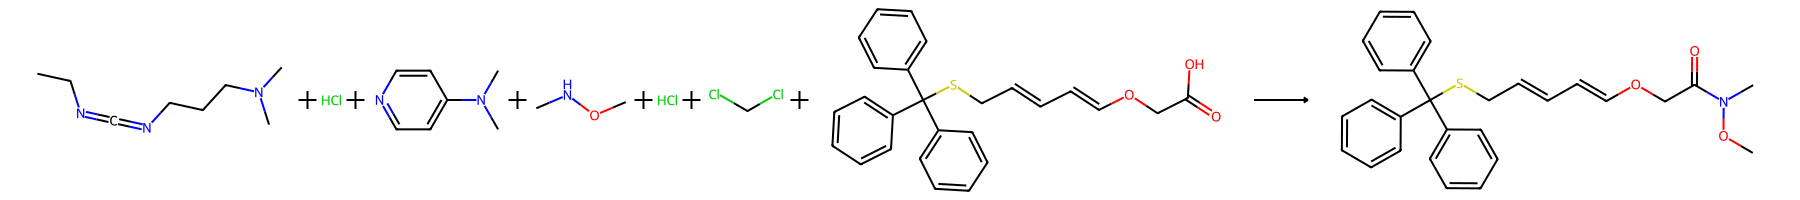

In [12]:
#display molecular reaction paths
for index, path in enumerate(results["retrosynthetic_paths"]):
    print(f"Showing path {index} with confidence {path['confidence']}")
    for reaction in collect_reactions_from_retrosynthesis(path):
        display(Chem.Draw.ReactionToImage(reaction))